### 평가 지표 결과 사람 평가의 정렬을 위한 정성분석

In [ ]:
from colorama import Fore, Style
import pandas as pd
import numpy as np
import json
from rouge import Rouge
from konlpy.tag import Okt
from bert_score import score
import os
import sys
sys.setrecursionlimit(10000)
from utils.utils import (
    MODEL_MAPPING, format_time, setup_logging,
    load_environment, save_json
)

In [ ]:
def compute_rougeL_per_sample(generated_answers, gold_answers):
    okt = Okt()
    rouge = Rouge()
    
    # 형태소 단위로 계산
    generated_answers_morphs = [" ".join(okt.morphs(g)) for g in generated_answers]
    gold_answers_morphs = [" ".join(okt.morphs(p)) for p in gold_answers]

    scores = []
    for g, p in zip(generated_answers_morphs, gold_answers_morphs):
        scores.append(rouge.get_scores(g, p)[0]['rouge-l']['f'])
    
    return scores
    
def compute_bertscore_per_sample(generated_answers, gold_answers):
    valid_pairs = [(g, p) for g, p in zip(generated_answers, gold_answers)]
        
    valid_gen, valid_gold = zip(*valid_pairs)
    _, _, F1 = score(
        valid_gen,
        valid_gold, 
        lang="ko"  # 다국어 모델: "bert-base-multilingual-cased"
    )
    
    return F1.tolist()

def find_extreme_samples(df, scores, metric_name, k=100):
    scores_array = np.array(scores)
    
    top_indices = np.argsort(scores_array)[-k:][::-1]
    bottom_indices = np.argsort(scores_array)[:k]
    
    def create_sample_info(idx):
        return {
            "id": (int(df.iloc[idx]['q_id']), int(df.iloc[idx]['a_id'])),
            "question": df.iloc[idx].get('preprocessed_question'),
            "model_answer": df.iloc[idx]['generated_answer'],
            "human_answer": df.iloc[idx]['preprocessed_answer'],
            "score": float(scores[idx])
        }
    
    return {
        f"{metric_name}_top_{k}": [create_sample_info(idx) for idx in top_indices],
        f"{metric_name}_bottom_{k}": [create_sample_info(idx) for idx in bottom_indices]
    }

if __name__ == "__main__":
    env = load_environment()
    file_path = "/home/work/factchecking/PetQA/outputs/results/generated_answers/output_exaone-3.5-7.8b_0_preprocessed.json"
    df = pd.read_json(file_path)
    results = []
    
    q_ids = df['q_id']
    a_ids = df['a_id']
    generated_answers = df['generated_answer']
    gold_answers = df['preprocessed_answer']

    rougeL_scores = compute_rougeL_per_sample(generated_answers, gold_answers)
    # bertscore_scores = compute_bertscore_per_sample(list(generated_answers), list(gold_answers))
    
    results = {}
    # 각 지표별 극값 샘플 찾기
    rouge_extremes = find_extreme_samples(df, rougeL_scores, "rouge_l")
    # bertscore_extremes = find_extreme_samples(df, bertscore_scores, "bertscore")
    
    results.update(rouge_extremes)
    # results.update(bertscore_extremes)
    
    output_path = "./extreme_samples_rouge_analysis.json"
    save_json(results, output_path)
    

In [30]:
import json
import tiktoken
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from collections import Counter
import pandas as pd

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


encoding = tiktoken.encoding_for_model("gpt-4o-mini")
def get_token_count(text):
    return len(encoding.encode(text))

### 등급별 일반인 분석

In [31]:
from collections import Counter

file_path = "/home/work/factchecking/PetQA/data/interim/merged_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
    
selected_nonexpert = []

for item in data:
    for answer in item["answers"]:
        if answer["expert_badge"] == "전문가가 아님" and answer["selected"] == True:
            selected_nonexpert.append(answer)

badge_distribution = Counter([item["badge"] for item in selected_nonexpert])
badge_distribution

Counter({'수호신': 7369,
         '초인': 5676,
         '은하신': 5054,
         '영웅': 4038,
         '우주신': 3910,
         '지존': 3480,
         '고수': 2464,
         '식물신': 2424,
         '별신': 2244,
         '물신': 2195,
         '바람신': 2085,
         '태양신': 2068,
         '초수': 2000,
         '중수': 1839,
         '달신': 1099,
         '뱃지 없음': 979,
         '시민': 754,
         '절대신': 413,
         '지식카페': 352,
         '평민': 54,
         '': 7,
         '지식파트너': 1})

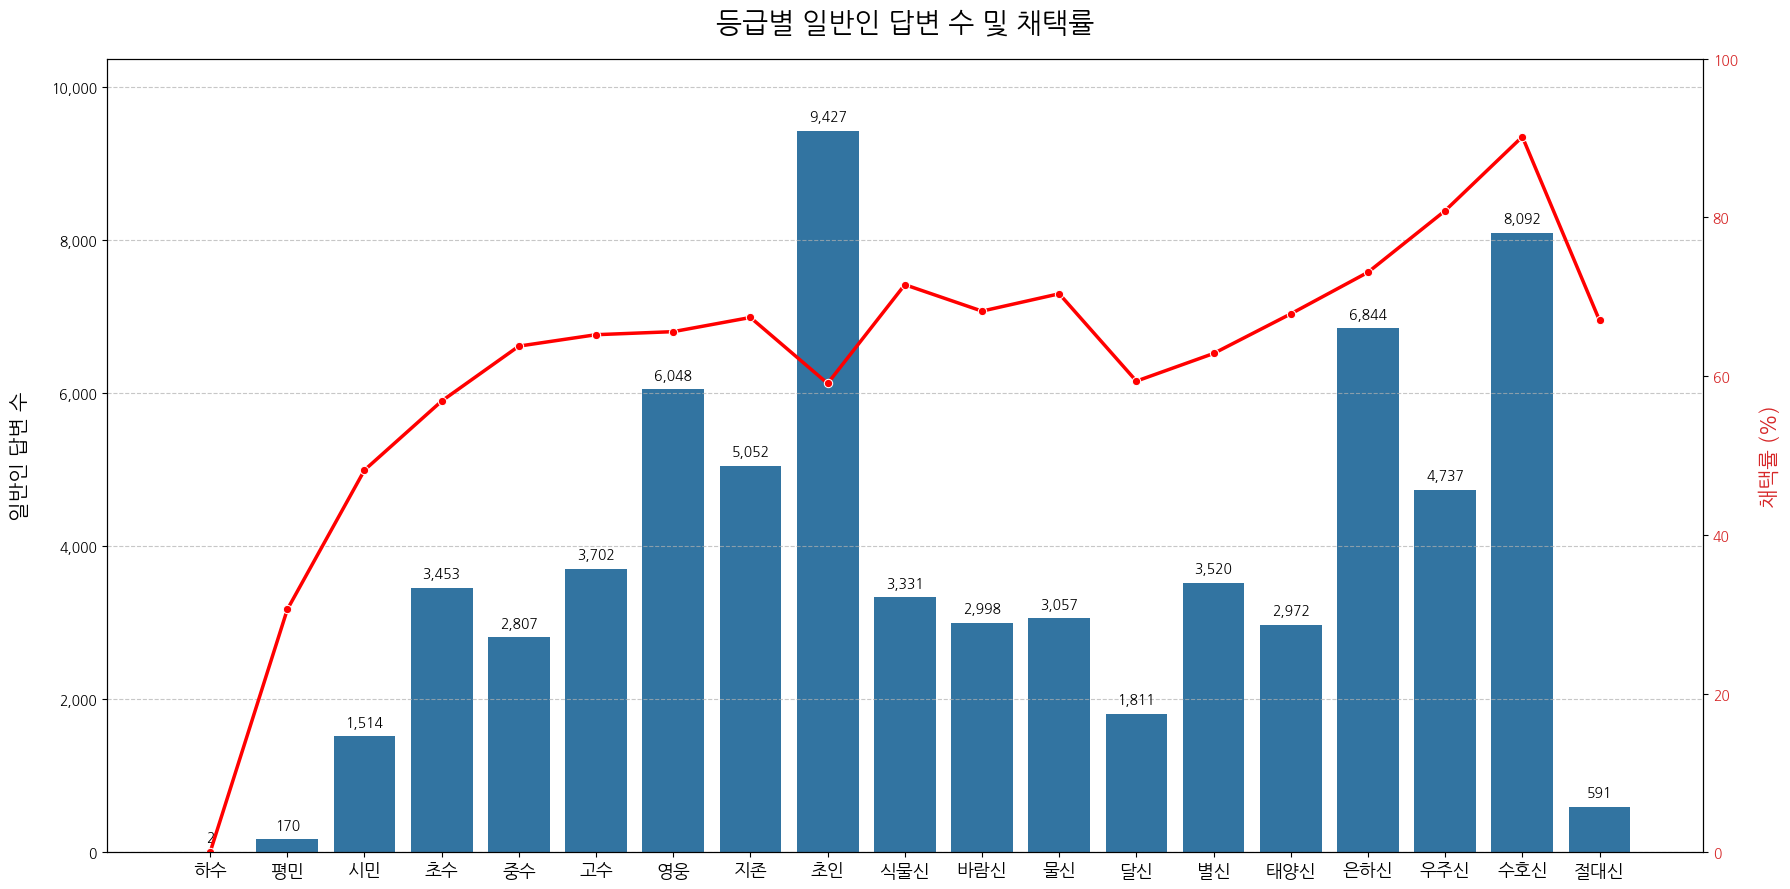

np.float64(60.47835032148405)

In [ ]:
from collections import Counter

file_path = "/home/work/factchecking/PetQA/src/preprocessing/extracted_data_w_badge.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

total_nonexpert_answers = Counter()
selected_nonexpert_answers = Counter()

for item in data:
    for answer in item["answers"]:
        if answer["answer_type"] == "nonexpert":
            badge = answer.get("badge", "") 
            total_nonexpert_answers[badge] += 1
            if answer["selected"] == True:
                selected_nonexpert_answers[badge] += 1

acceptance_rates = {}
for badge, total_count in total_nonexpert_answers.items():
    selected_count = selected_nonexpert_answers.get(badge, 0)
    if total_count > 0:
        rate = (selected_count / total_count) * 100
        acceptance_rates[badge] = rate
    else:
        acceptance_rates[badge] = 0

df_data = pd.DataFrame([
    {'뱃지 종류': badge, 
     '총 일반인 답변 수': total_nonexpert_answers[badge], 
     '채택된 일반인 답변 수': selected_nonexpert_answers.get(badge, 0), 
     '채택률 (%)': acceptance_rates[badge]}
    for badge in total_nonexpert_answers.keys()
])

ordered_badges = [
    '하수', '평민', '시민', '초수', '중수', '고수', '영웅', '지존', '초인',
    '식물신', '바람신', '물신', '달신', '별신', '태양신', '은하신', '우주신', '수호신', '절대신'
]

df_ordered = df_data.set_index('뱃지 종류').reindex(ordered_badges).reset_index()
df_ordered['채택된 일반인 답변 수'] = df_ordered['채택된 일반인 답변 수'].fillna(0)
df_ordered['채택률 (%)'] = df_ordered['채택률 (%)'].fillna(0)
df_ordered['총 일반인 답변 수'] = df_ordered['총 일반인 답변 수'].fillna(0)

fig, ax1 = plt.subplots(figsize=(18, 9))
sns.barplot(x='뱃지 종류', y='총 일반인 답변 수', data=df_ordered, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel('일반인 답변 수', fontsize=15, labelpad=15)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y')
ax1.set_ylim(0, (df_ordered['총 일반인 답변 수'].max() * 1.1 if not df_ordered.empty else 7500))

# 각 막대 위에 채택된 답변 수 값 표시
for index, row in df_ordered.iterrows():
    if pd.notna(row['총 일반인 답변 수']) and row['총 일반인 답변 수'] > 0:
        ax1.text(index, row['총 일반인 답변 수'] + 100, 
                 f"{int(row['총 일반인 답변 수']):,}", 
                 color='black', ha="center", va='bottom', fontsize=10)

ax2 = ax1.twinx()
sns.lineplot(x='뱃지 종류', y='채택률 (%)', data=df_ordered, marker='o', 
             dashes=False, color='red', linewidth=2.5, ax=ax2)

ax2.set_xlabel("")
ax2.set_ylabel('채택률 (%)', color='tab:red', fontsize=15, labelpad=15)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 100)


plt.title('등급별 일반인 답변 수 및 채택률', fontsize=20, pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

np.mean(list(acceptance_rates.values()))

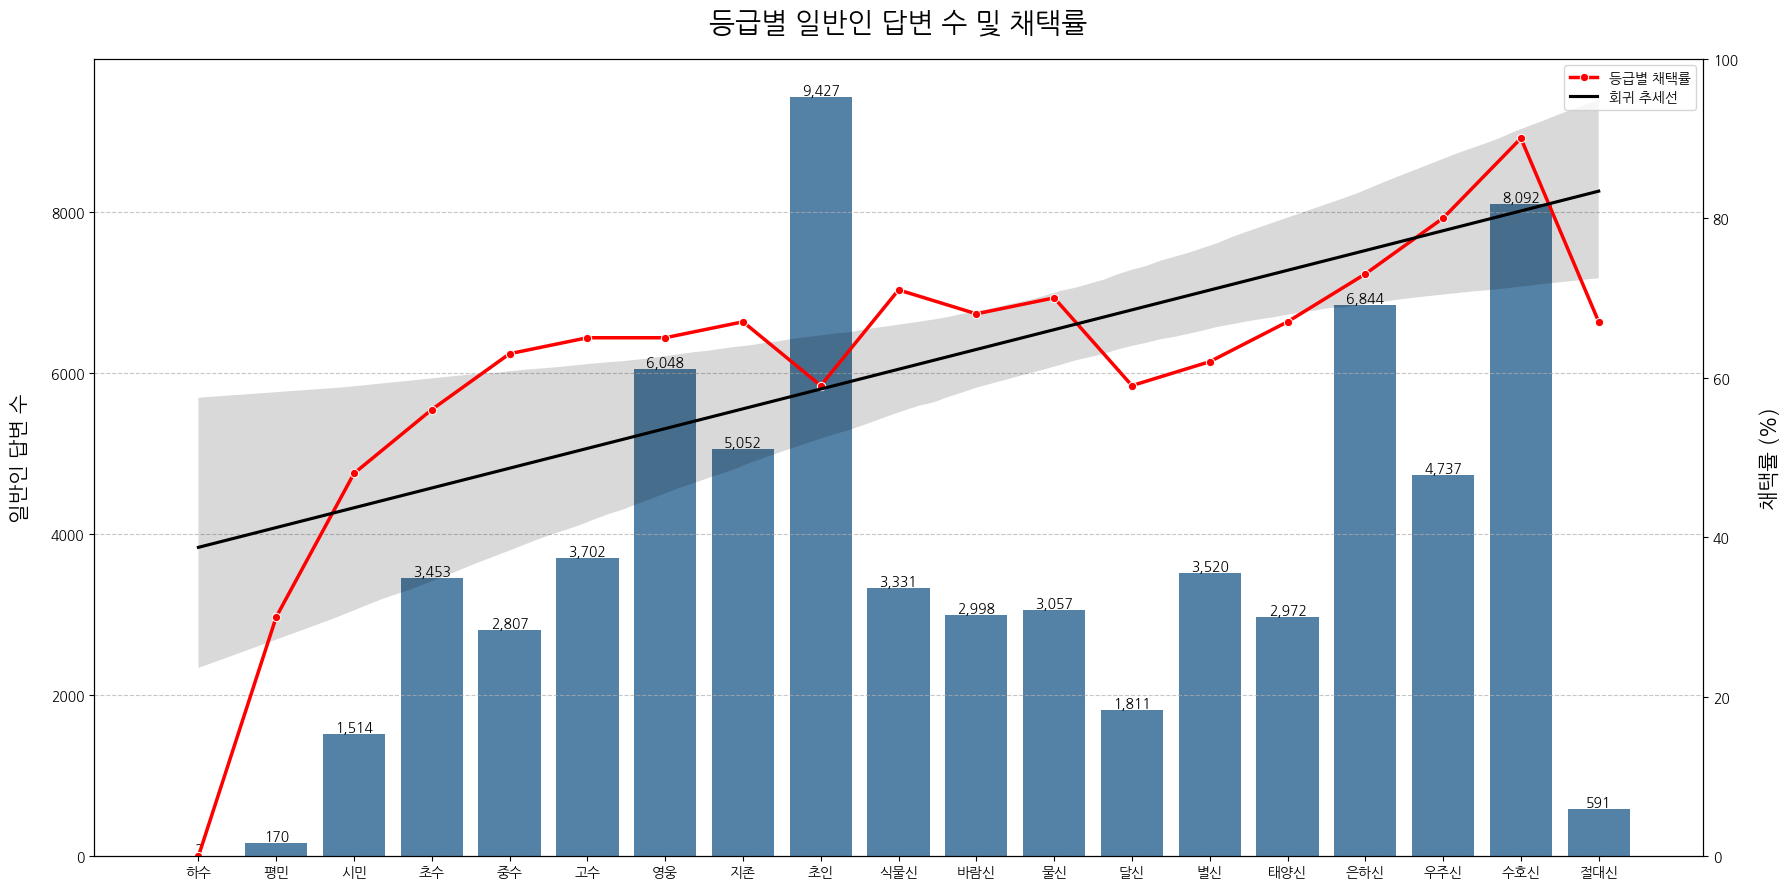

In [50]:
total_nonexpert_answers = Counter()
selected_nonexpert_answers = Counter()

for item in data:
    for answer in item["answers"]:
        if answer["answer_type"] == "nonexpert":
            badge = answer.get("badge", "") 
            total_nonexpert_answers[badge] += 1
            if answer["selected"] == True:
                selected_nonexpert_answers[badge] += 1

acceptance_rates = {}
for badge, total_count in total_nonexpert_answers.items():
    selected_count = selected_nonexpert_answers.get(badge, 0)
    rate = (selected_count / total_count) * 100 if total_count > 0 else 0
    acceptance_rates[badge] = rate

df_data = pd.DataFrame([
    {'뱃지 종류': badge, 
     '총 일반인 답변 수': total_nonexpert_answers[badge], 
     '채택된 일반인 답변 수': selected_nonexpert_answers.get(badge, 0), 
     '채택률 (%)': acceptance_rates.get(badge, 0)}
    for badge in total_nonexpert_answers.keys()
])

df_ordered = df_data.set_index('뱃지 종류').reindex(ordered_badges).reset_index()
# NaN 값을 0으로 채우기
for col in ['총 일반인 답변 수', '채택된 일반인 답변 수', '채택률 (%)']:
    df_ordered[col] = df_ordered[col].fillna(0).astype(int)

# 선형 회귀 분석을 위한 숫자형 순서 컬럼 추가
df_ordered['등급순서'] = np.arange(len(df_ordered))

fig, ax1 = plt.subplots(figsize=(18, 9))

# 막대 그래프
sns.barplot(x='뱃지 종류', y='총 일반인 답변 수', data=df_ordered, ax=ax1, color='steelblue')
ax1.set_xlabel("")
ax1.set_ylabel('일반인 답변 수', fontsize=15, labelpad=15)
for index, row in df_ordered.iterrows():
    if row['총 일반인 답변 수'] > 0:
        ax1.text(index, row['총 일반인 답변 수'], f"{int(row['총 일반인 답변 수']):,}", 
                 color='black', ha="center", va='bottom', fontsize=10)

ax2 = ax1.twinx()

# 채택률
sns.lineplot(x='뱃지 종류', y='채택률 (%)', data=df_ordered, marker='o', 
             dashes=False, color='red', linewidth=2.5, ax=ax2, label='등급별 채택률')

# 선형 회귀선
sns.regplot(x='등급순서', y='채택률 (%)', data=df_ordered, ax=ax2, scatter=False,
            line_kws={"linestyle": "-", "color": "black"}, label='회귀 추세선')

ax2.set_ylabel('채택률 (%)', fontsize=15, labelpad=15)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)

plt.title('등급별 일반인 답변 수 및 채택률', fontsize=20, pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [1]:
import json
import os

add_badges_raw_dir_path = "/home/work/factchecking/PetQA/data/raw/add_badge/"
interim_dir_path = "/home/work/factchecking/PetQA/data/interim/"
file_list = [f for f in os.listdir(add_badges_raw_dir_path) if f.endswith('.json')]

merged_data = []
for file_name in file_list:
    file_path = os.path.join(add_badges_raw_dir_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    merged_data.extend(data)
print(f"총 샘플의 수: {len(merged_data)}")

NULL_STR = "본 게시물은 개인정보노출 또는 서비스 운영원칙에 위배된 내용이 포함되어 삭제되었습니다."

neutral_data_count = 0
null_data_count = 0
extracted_data = []
for item in merged_data:
    if item.get("label_str") == "neutral":
        neutral_data_count += 1
        continue
    if item.get("제목") == NULL_STR:
        null_data_count += 1
        continue
    
    new_item = {
        "title": item.get("제목"),
        "content": item.get("본문", ""),
        "answers": [],
        "question_date": item.get("question_date"),
        "animal_type": item.get("label_str"),
        "link": item.get("link")
    }
    
    for a_id, answer in enumerate(item["answers"]):
        answer_type = "expert" if answer.get("expert_badge") == "수의사" else "nonexpert"
        new_answer = {
            "a_id": a_id,
            "answer_type": answer_type,
            "answer": answer.get("답변"),
            "selected": answer.get("selected"),
            "badge": answer.get("badge"),
            "name": answer.get("name"),
            "institution": answer.get("institution", ""),
            "answer_date": answer.get("answer_date")
        }
        new_item["answers"].append(new_answer)
    extracted_data.append(new_item)
    
print(f"중립 데이터 수: {neutral_data_count}")
print(f"삭제된 데이터 수: {null_data_count}")
print(f"추출된 샘플 수: {len(extracted_data)}")

unique_data = []
duplicated_data = 0
q_id_count = 0
seen_titles_contents = set()

for item in extracted_data:
    identifier = (item['title'], item['content'])
    if identifier in seen_titles_contents:
        duplicated_data += 1
    else:
        seen_titles_contents.add(identifier)
        new_item = {"q_id": q_id_count}
        new_item.update(item)
        unique_data.append(new_item)
        q_id_count += 1

print(f"중복된 데이터: {duplicated_data}개")
print(f"고유한 샘플 수: {len(unique_data)}개")

총 샘플의 수: 64921
중립 데이터 수: 1330
삭제된 데이터 수: 8
추출된 샘플 수: 63583
중복된 데이터: 4411개
고유한 샘플 수: 59172개


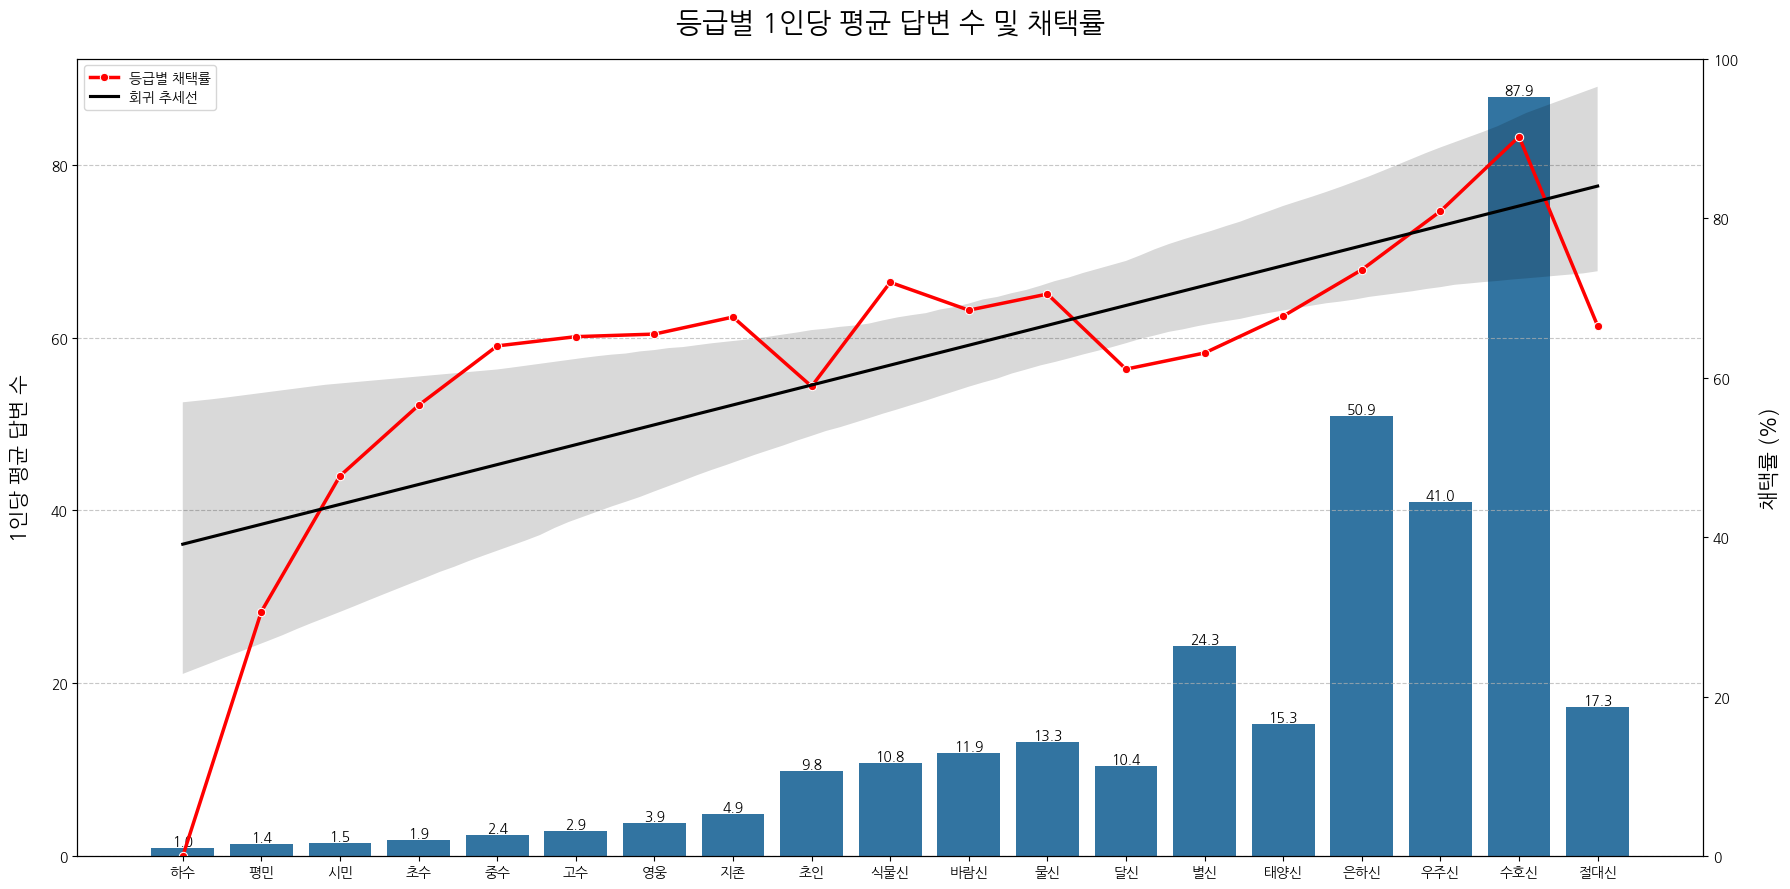

In [2]:
import json
import tiktoken
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from collections import Counter
import pandas as pd

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


encoding = tiktoken.encoding_for_model("gpt-4o-mini")
def get_token_count(text):
    return len(encoding.encode(text))

total_nonexpert_answers = Counter()
selected_nonexpert_answers = Counter()
unique_users_per_badge = {}

for item in unique_data:
    for answer in item["answers"]:
        if answer["answer_type"] == "nonexpert":
            badge = answer.get("badge", "")
            name = answer.get("name", "")
            
            if not badge or not name:
                continue
            
            total_nonexpert_answers[badge] += 1
            if answer["selected"] == True:
                selected_nonexpert_answers[badge] += 1

            # 등급별 고유 답변자 이름 저장
            if badge not in unique_users_per_badge:
                unique_users_per_badge[badge] = set()
            unique_users_per_badge[badge].add(name)
            
num_users_per_badge = {badge: len(users) for badge, users in unique_users_per_badge.items()}
avg_answers_per_user = {
    badge: (total_count / num_users_per_badge.get(badge, 1))
    for badge, total_count in total_nonexpert_answers.items()
}
acceptance_rates = {
    badge: (selected_nonexpert_answers.get(badge, 0) / total_count) * 100 if total_count > 0 else 0
    for badge, total_count in total_nonexpert_answers.items()
}

# [수정] DataFrame 생성 시 '답변자 수', '1인당 평균 답변 수' 컬럼 추가
df_data = pd.DataFrame([
    {
        '뱃지 종류': badge, 
        '총 일반인 답변 수': total_nonexpert_answers.get(badge, 0),
        '답변자 수': num_users_per_badge.get(badge, 0),
        '1인당 평균 답변 수': avg_answers_per_user.get(badge, 0),
        '채택된 일반인 답변 수': selected_nonexpert_answers.get(badge, 0),
        '채택률 (%)': acceptance_rates.get(badge, 0)
    }
    for badge in total_nonexpert_answers.keys()
])

ordered_badges = [
    '하수', '평민', '시민', '초수', '중수', '고수', '영웅', '지존', '초인',
    '식물신', '바람신', '물신', '달신', '별신', '태양신', '은하신', '우주신', '수호신', '절대신'
]
df_ordered = df_data.set_index('뱃지 종류').reindex(ordered_badges).reset_index()

for col in ['총 일반인 답변 수', '답변자 수', '채택된 일반인 답변 수']:
    df_ordered[col] = df_ordered[col].fillna(0).astype(int)
for col in ['1인당 평균 답변 수', '채택률 (%)']:
    df_ordered[col] = df_ordered[col].fillna(0) # 실수형 데이터로 유지

df_ordered['등급순서'] = np.arange(len(df_ordered))

fig, ax1 = plt.subplots(figsize=(18, 9))

# 막대 그래프 (y축을 '1인당 평균 답변 수'로 변경)
sns.barplot(x='뱃지 종류', y='1인당 평균 답변 수', data=df_ordered, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel('1인당 평균 답변 수', fontsize=15, labelpad=15)

# 막대 위에 값 표시 (소수점 첫째 자리까지)
for index, row in df_ordered.iterrows():
    if row['1인당 평균 답변 수'] > 0:
        ax1.text(index, row['1인당 평균 답변 수'], f"{row['1인당 평균 답변 수']:.1f}", 
                 color='black', ha="center", va='bottom', fontsize=10)

# 꺾은선 그래프 (채택률)
ax2 = ax1.twinx()
sns.lineplot(x='뱃지 종류', y='채택률 (%)', data=df_ordered, marker='o', 
             dashes=False, color='red', linewidth=2.5, ax=ax2, label='등급별 채택률')
sns.regplot(x='등급순서', y='채택률 (%)', data=df_ordered, ax=ax2, scatter=False,
            line_kws={"linestyle": "-", "color": "black"}, label='회귀 추세선')

ax2.set_ylabel('채택률 (%)', fontsize=15, labelpad=15)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)

# 차트 제목 및 기타 설정
plt.title('등급별 1인당 평균 답변 수 및 채택률', fontsize=20, pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

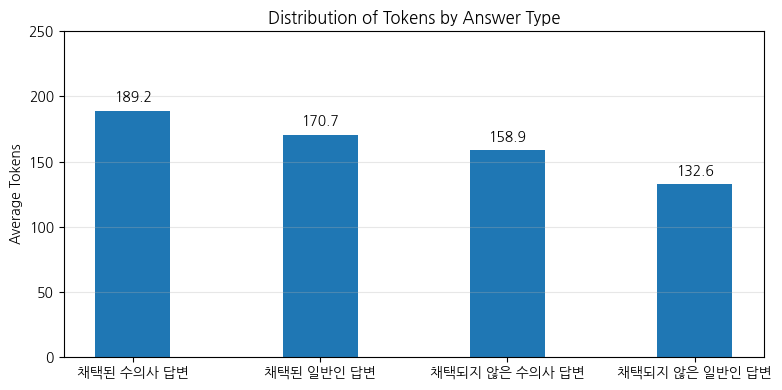

In [4]:
# 채택된 일반인 답변과 채택된 전문가 답변 토큰의 수 비교
file_path = "/home/work/factchecking/PetQA/data/interim/dpo_cleaned_data.json"
with open(file_path, "r") as f:
    data = json.load(f)

chosen_expert_answers = []
rejected_expert_answers = []
chosen_nonexpert_answers = []
rejected_nonexpert_answers = []

for item in data:
    if item["chosen"]["answer_type"] == "expert":
        chosen_expert_answers.append(item["chosen"]["answer"])
    else:
        chosen_nonexpert_answers.append(item["chosen"]["answer"])
    if item["rejected"]["answer_type"] == "expert":
        rejected_expert_answers.append(item["rejected"]["answer"])
    else:
        rejected_nonexpert_answers.append(item["rejected"]["answer"])

categories = [
    ("채택된 수의사 답변", chosen_expert_answers),
    ("채택된 일반인 답변", chosen_nonexpert_answers),
    ("채택되지 않은 수의사 답변", rejected_expert_answers),
    ("채택되지 않은 일반인 답변", rejected_nonexpert_answers)
]

for category_name, answers in categories:
    token_counts = [get_token_count(answer) for answer in answers]
    avg_tokens = sum(token_counts) / len(token_counts)
    total_tokens = sum(token_counts)
    max_tokens = max(token_counts)
    min_tokens = min(token_counts)
    
    # print(f"\n=== {category_name} ===")
    # print(f"답변 수: {len(answers)}")
    # print(f"평균 토큰 수: {avg_tokens:.2f}")
    # print(f"최대 토큰 수: {max_tokens}")
    # print(f"최소 토큰 수: {min_tokens}")
    
category_labels = []
avg_token_counts = []

for category_name, answers in categories:
    token_counts = [get_token_count(answer) for answer in answers]
    avg_tokens = sum(token_counts) / len(token_counts)

    category_labels.append(category_name)
    avg_token_counts.append(avg_tokens)

plt.figure(figsize=(8, 4))
bars = plt.bar(category_labels, avg_token_counts, width=0.4)
plt.title("Distribution of Tokens by Answer Type")
plt.ylabel("Average Tokens")
plt.ylim(0, 250)
# plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# 막대 위에 수치 출력
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f"{height:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

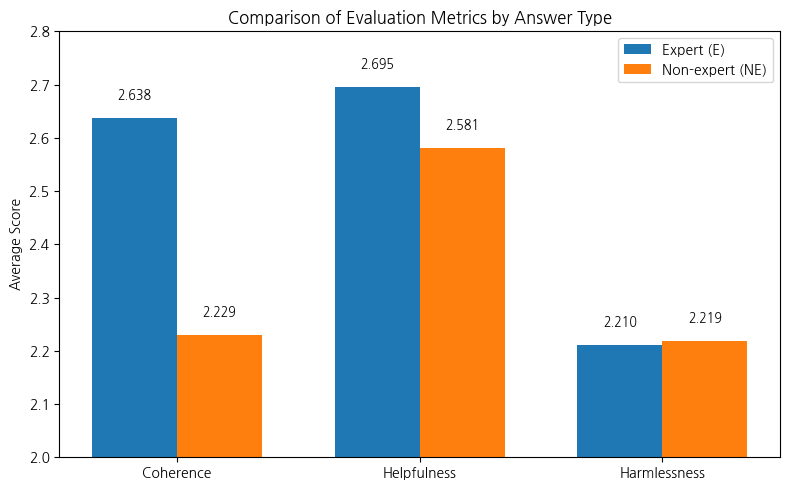

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

file_path = "/home/work/factchecking/PetQA/data/interim/ne_chosen_e_rejected.json"

metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
expert_values = [2.638, 2.695, 2.210]
nonexpert_values = [2.229, 2.581, 2.219]

x = np.arange(len(metrics))  # x축 위치: [0, 1, 2]
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, expert_values, width, label='Expert (E)')
bars2 = ax.bar(x + width/2, nonexpert_values, width, label='Non-expert (NE)')

# 축 라벨 및 제목 설정
ax.set_ylabel('Average Score')
ax.set_title('Comparison of Evaluation Metrics by Answer Type')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# 바 위에 값 표시
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

plt.ylim(2.0, 2.8)  # y축 범위 조정 (선택사항)
plt.tight_layout()
plt.show()


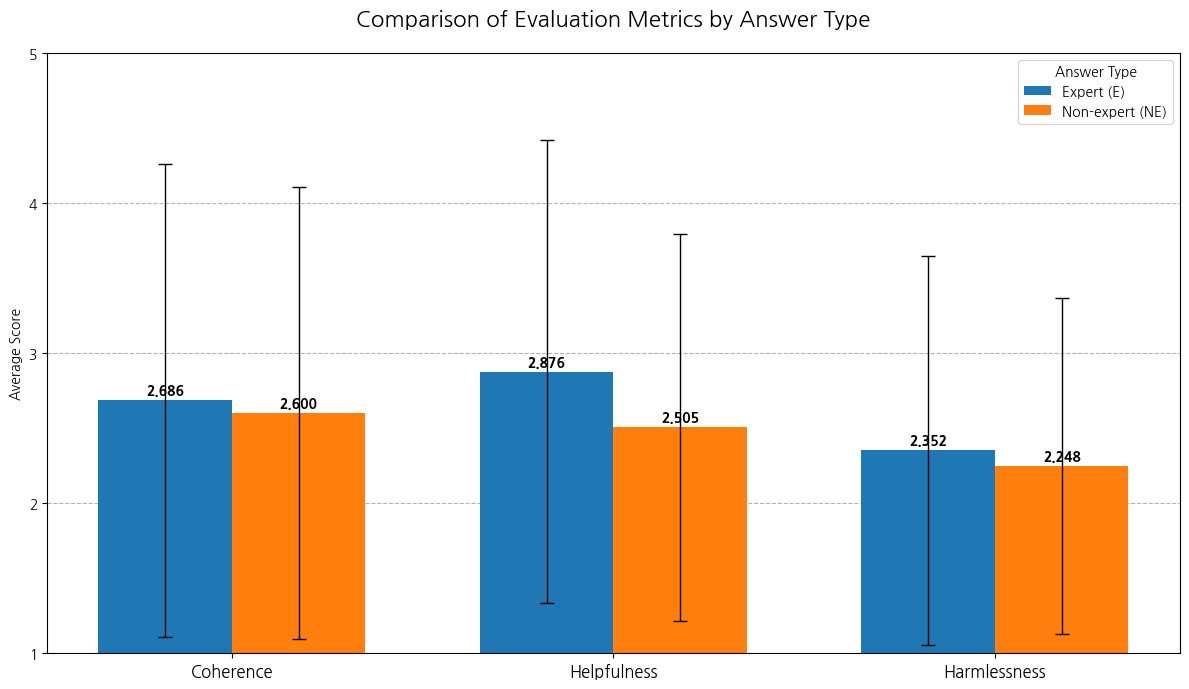

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

file_path = "/home/work/factchecking/PetQA/src/evaluation/prometheus_results_selected_ne_105.json"

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

evaluation_results = data[0] # 첫 번째 평가 결과 셋을 사용

metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
expert_values = []
nonexpert_values = []
expert_std_dev = [] # 표준 편차 (수직선 길이 계산에 사용 가능)
nonexpert_std_dev = []

for metric_name_lower in ['coherence', 'helpfulness', 'harmlessness']:
    scores_data = evaluation_results[metric_name_lower]
    
    e_scores = np.array(scores_data["rejected_e_score"])
    expert_values.append(np.mean(e_scores))
    expert_std_dev.append(np.std(e_scores))
    
    ne_scores = np.array(scores_data["selected_ne_score"])
    nonexpert_values.append(np.mean(ne_scores))
    nonexpert_std_dev.append(np.std(ne_scores))

x = np.arange(len(metrics))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7)) # 원본 이미지에 맞춰 더 크게 조정

# Expert 막대 (error bar 추가)
bars1 = ax.bar(x - width/2, expert_values, width, 
               yerr=expert_std_dev,  # error bar 추가
               label='Expert (E)', color='#1f77b4',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

# Non-expert 막대 (error bar 추가)
bars2 = ax.bar(x + width/2, nonexpert_values, width, 
               yerr=nonexpert_std_dev,  # error bar 추가
               label='Non-expert (NE)', color='#ff7f0e',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

ax.set_ylabel('Average Score')
ax.set_title('Comparison of Evaluation Metrics by Answer Type', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(title="Answer Type", loc="upper right", fontsize=10, title_fontsize=10)

ax.set_ylim(1.0, 5.0)
ax.set_yticks(np.arange(1.0, 5.01, 1))

ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
ax.set_axisbelow(True)

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

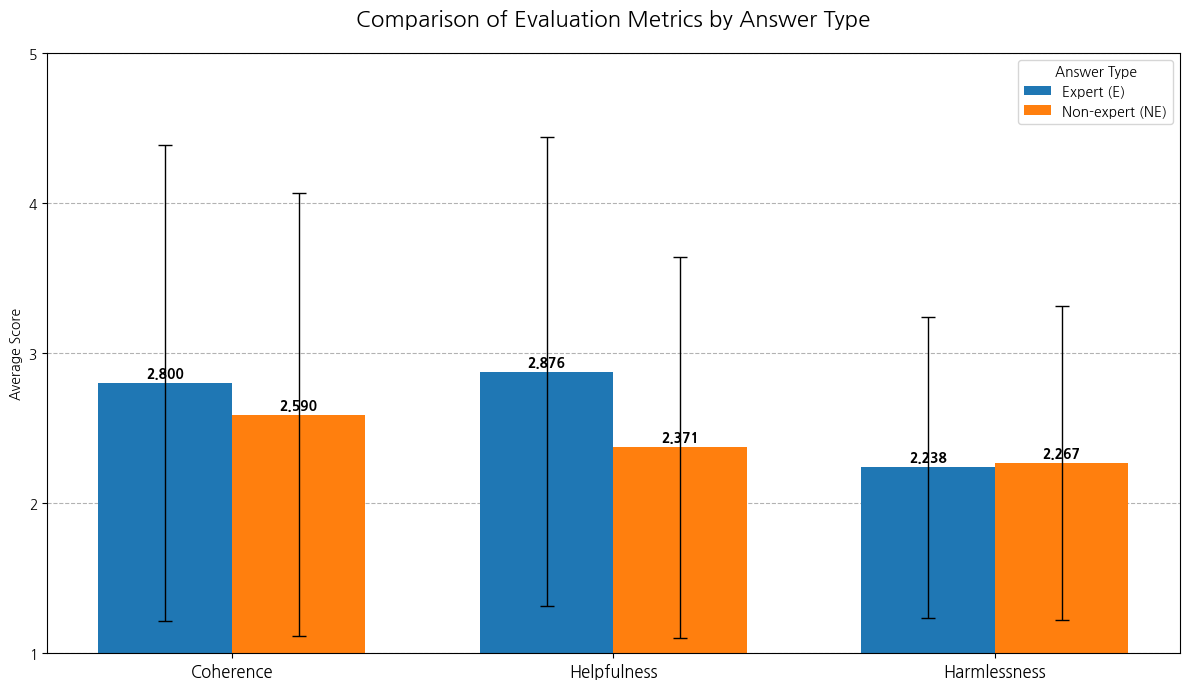

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

file_path = "/home/work/factchecking/PetQA/src/evaluation/prometheus_results_selected_ne_105_v2.json"

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

evaluation_results = data[0] # 첫 번째 평가 결과 셋을 사용

metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
expert_values = []
nonexpert_values = []
expert_std_dev = [] # 표준 편차 (수직선 길이 계산에 사용 가능)
nonexpert_std_dev = []

for metric_name_lower in ['coherence', 'helpfulness', 'harmlessness']:
    scores_data = evaluation_results[metric_name_lower]
    
    e_scores = np.array(scores_data["rejected_e_score"])
    expert_values.append(np.mean(e_scores))
    expert_std_dev.append(np.std(e_scores))
    
    ne_scores = np.array(scores_data["selected_ne_score"])
    nonexpert_values.append(np.mean(ne_scores))
    nonexpert_std_dev.append(np.std(ne_scores))

x = np.arange(len(metrics))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7)) # 원본 이미지에 맞춰 더 크게 조정

# Expert 막대 (error bar 추가)
bars1 = ax.bar(x - width/2, expert_values, width, 
               yerr=expert_std_dev,  # error bar 추가
               label='Expert (E)', color='#1f77b4',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

# Non-expert 막대 (error bar 추가)
bars2 = ax.bar(x + width/2, nonexpert_values, width, 
               yerr=nonexpert_std_dev,  # error bar 추가
               label='Non-expert (NE)', color='#ff7f0e',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

ax.set_ylabel('Average Score')
ax.set_title('Comparison of Evaluation Metrics by Answer Type', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(title="Answer Type", loc="upper right", fontsize=10, title_fontsize=10)

ax.set_ylim(1.0, 5.0)
ax.set_yticks(np.arange(1.0, 5.01, 1))

ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
ax.set_axisbelow(True)

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

file_path = "/home/work/factchecking/PetQA/src/evaluation/prometheus_results_selected_ne_105_v3.json"

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

evaluation_results = data[0] # 첫 번째 평가 결과 셋을 사용

metrics = ['Coherence', 'Helpfulness', 'Harmlessness']
expert_values = []
nonexpert_values = []
expert_std_dev = [] # 표준 편차 (수직선 길이 계산에 사용 가능)
nonexpert_std_dev = []

for metric_name_lower in ['coherence', 'helpfulness', 'harmlessness']:
    scores_data = evaluation_results[metric_name_lower]
    
    e_scores = np.array(scores_data["rejected_e_score"])
    expert_values.append(np.mean(e_scores))
    expert_std_dev.append(np.std(e_scores))
    
    ne_scores = np.array(scores_data["selected_ne_score"])
    nonexpert_values.append(np.mean(ne_scores))
    nonexpert_std_dev.append(np.std(ne_scores))

x = np.arange(len(metrics))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(12, 7)) # 원본 이미지에 맞춰 더 크게 조정

# Expert 막대 (error bar 추가)
bars1 = ax.bar(x - width/2, expert_values, width, 
               yerr=expert_std_dev,  # error bar 추가
               label='Expert (E)', color='#1f77b4',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

# Non-expert 막대 (error bar 추가)
bars2 = ax.bar(x + width/2, nonexpert_values, width, 
               yerr=nonexpert_std_dev,  # error bar 추가
               label='Non-expert (NE)', color='#ff7f0e',
               capsize=5,  # error bar 끝부분 가로선 길이
               error_kw={'elinewidth': 1, 'capthick': 1})  # error bar 스타일

ax.set_ylabel('Average Score')
ax.set_title('Comparison of Evaluation Metrics by Answer Type', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(title="Answer Type", loc="upper right", fontsize=10, title_fontsize=10)

ax.set_ylim(1.0, 5.0)
ax.set_yticks(np.arange(1.0, 5.01, 1))

ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
ax.set_axisbelow(True)

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import json
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

def analyze_dpo_token_usage(json_file_path, model_name="LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct"):
    """
    DPO 훈련 데이터의 토큰 사용량 분석
    """
    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # 데이터 로드
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print(f"총 데이터 샘플 수: {len(data)}")
    
    # 토큰 분석 결과 저장
    token_stats = []
    
    for i, item in enumerate(data):
        # 각 구성 요소 토큰화
        prompt = item["preprocessed_question"]
        chosen = item["chosen"]["preprocessed_answer"] 
        rejected = item["rejected"]["preprocessed_answer"]
        
        # 토큰 수 계산
        prompt_tokens = len(tokenizer.encode(prompt, add_special_tokens=False))
        chosen_tokens = len(tokenizer.encode(chosen, add_special_tokens=False))
        rejected_tokens = len(tokenizer.encode(rejected, add_special_tokens=False))
        
        # DPO에서 실제 사용되는 형태로 결합
        # Format: <prompt><eos><response>
        prompt_chosen_text = prompt + tokenizer.eos_token + chosen
        prompt_rejected_text = prompt + tokenizer.eos_token + rejected
        
        prompt_chosen_total = len(tokenizer.encode(prompt_chosen_text, add_special_tokens=True))
        prompt_rejected_total = len(tokenizer.encode(prompt_rejected_text, add_special_tokens=True))
        
        # DPO 훈련에서 실제 처리되는 최대 토큰 수
        max_tokens_per_sample = max(prompt_chosen_total, prompt_rejected_total)
        
        token_stat = {
            'index': i,
            'prompt_tokens': prompt_tokens,
            'chosen_tokens': chosen_tokens,
            'rejected_tokens': rejected_tokens,
            'prompt_chosen_total': prompt_chosen_total,
            'prompt_rejected_total': prompt_rejected_total,
            'max_tokens_per_sample': max_tokens_per_sample,
            'chosen_answer_type': item['chosen_answer_type'],
            'rejected_answer_type': item['rejected_answer_type']
        }
        
        token_stats.append(token_stat)
    return token_stats, tokenizer

def calculate_training_memory_requirements(token_stats, config):
    """
    DPO 훈련 메모리 요구사항 계산
    """
    batch_size = config.get('per_device_train_batch_size', 1)
    gradient_accumulation_steps = config.get('gradient_accumulation_steps', 4)
    max_length = config.get('max_length', 2048)
    
    # 토큰 수 통계
    max_tokens = [stat['max_tokens_per_sample'] for stat in token_stats]
    avg_tokens = np.mean(max_tokens)
    p95_tokens = np.percentile(max_tokens, 95)
    p99_tokens = np.percentile(max_tokens, 99)
    
    # 실제 훈련에서 사용될 토큰 수 (max_length로 제한됨)
    effective_tokens = [min(tokens, max_length) for tokens in max_tokens]
    avg_effective_tokens = np.mean(effective_tokens)
    
    print("\n=== 토큰 사용량 통계 ===")
    print(f"평균 토큰 수: {avg_tokens:.1f}")
    print(f"95%ile 토큰 수: {p95_tokens:.1f}")
    print(f"99%ile 토큰 수: {p99_tokens:.1f}")
    print(f"최대 토큰 수: {max(max_tokens)}")
    print(f"max_length 제한 후 평균: {avg_effective_tokens:.1f}")
    
    # DPO 특수 계산: 각 샘플당 4번의 forward pass 
    # (policy_chosen, policy_rejected, ref_chosen, ref_rejected)
    tokens_per_forward_pass = avg_effective_tokens
    total_tokens_per_sample = tokens_per_forward_pass * 4  # DPO의 4번 forward
    
    # 배치 단위 토큰 수
    tokens_per_batch = total_tokens_per_sample * batch_size
    tokens_per_accumulation = tokens_per_batch * gradient_accumulation_steps
    
    print(f"\n=== DPO 훈련 토큰 계산 ===")
    print(f"샘플당 평균 토큰 수 (1번 forward): {tokens_per_forward_pass:.1f}")
    print(f"샘플당 총 토큰 수 (4번 forward): {total_tokens_per_sample:.1f}")
    print(f"배치당 토큰 수: {tokens_per_batch:.1f}")
    print(f"그래디언트 누적 단위 토큰 수: {tokens_per_accumulation:.1f}")
    
    return {
        'avg_tokens_per_sample': avg_tokens,
        'avg_effective_tokens': avg_effective_tokens,
        'total_tokens_per_sample': total_tokens_per_sample,
        'tokens_per_batch': tokens_per_batch,
        'tokens_per_accumulation': tokens_per_accumulation
    }

def analyze_token_distribution(token_stats):
    """
    토큰 분포 분석 및 시각화
    """
    # 데이터 추출
    prompt_tokens = [stat['prompt_tokens'] for stat in token_stats]
    chosen_tokens = [stat['chosen_tokens'] for stat in token_stats]
    rejected_tokens = [stat['rejected_tokens'] for stat in token_stats]
    max_tokens = [stat['max_tokens_per_sample'] for stat in token_stats]
    
    # 통계 계산
    stats_data = {
        'prompt': {
            'mean': np.mean(prompt_tokens),
            'std': np.std(prompt_tokens), 
            'min': np.min(prompt_tokens),
            'max': np.max(prompt_tokens),
            'p95': np.percentile(prompt_tokens, 95)
        },
        'chosen': {
            'mean': np.mean(chosen_tokens),
            'std': np.std(chosen_tokens),
            'min': np.min(chosen_tokens), 
            'max': np.max(chosen_tokens),
            'p95': np.percentile(chosen_tokens, 95)
        },
        'rejected': {
            'mean': np.mean(rejected_tokens),
            'std': np.std(rejected_tokens),
            'min': np.min(rejected_tokens),
            'max': np.max(rejected_tokens), 
            'p95': np.percentile(rejected_tokens, 95)
        },
        'total': {
            'mean': np.mean(max_tokens),
            'std': np.std(max_tokens),
            'min': np.min(max_tokens),
            'max': np.max(max_tokens),
            'p95': np.percentile(max_tokens, 95)
        }
    }
    
    print("\n=== 상세 토큰 분포 ===")
    for component, stats in stats_data.items():
        print(f"\n{component.upper()} 토큰:")
        print(f"  평균: {stats['mean']:.1f} ± {stats['std']:.1f}")
        print(f"  범위: {stats['min']:.0f} ~ {stats['max']:.0f}")
        print(f"  95%ile: {stats['p95']:.1f}")
    
    # max_length별 잘림 비율 계산
    truncation_rates = {}
    for max_len in [1024, 1536, 2048, 2560]:
        truncated = sum(1 for tokens in max_tokens if tokens > max_len)
        rate = truncated / len(max_tokens) * 100
        truncation_rates[max_len] = rate
        print(f"\nmax_length={max_len}일 때 잘림 비율: {rate:.1f}%")
    
    return stats_data, truncation_rates

def find_optimal_max_length(token_stats, target_truncation_rate=5.0):
    """
    목표 잘림 비율에 맞는 최적 max_length 찾기
    """
    max_tokens = [stat['max_tokens_per_sample'] for stat in token_stats]
    
    # 95%ile, 99%ile 등을 기준으로 권장값 제시
    p95 = np.percentile(max_tokens, 95)
    p99 = np.percentile(max_tokens, 99)
    p99_5 = np.percentile(max_tokens, 99.5)
    
    print(f"\n=== 최적 max_length 권장사항 ===")
    print(f"95% 데이터 수용: {int(p95)}")
    print(f"99% 데이터 수용: {int(p99)}")  
    print(f"99.5% 데이터 수용: {int(p99_5)}")
    
    return int(p95), int(p99), int(p99_5)

# 메인 실행 코드
if __name__ == "__main__":
    json_file_path = "/home/work/factchecking/PetQA/data/interim/dpo_cleaned_data.json"
    
    # 토큰 분석 실행
    print("토큰 분석 시작...")
    token_stats, tokenizer = analyze_dpo_token_usage(json_file_path)
    
    # 현재 DPO config (코드에서 사용 중인 설정)
    current_config = {
        'per_device_train_batch_size': 1,
        'gradient_accumulation_steps': 4, 
        'max_length': 2048
    }
    
    # 메모리 요구사항 계산
    memory_info = calculate_training_memory_requirements(token_stats, current_config)
    
    # 토큰 분포 분석
    stats_data, truncation_rates = analyze_token_distribution(token_stats)
    
    # 최적 max_length 찾기
    p95, p99, p99_5 = find_optimal_max_length(token_stats)
    
    # 권장사항 출력
    print(f"\n=== 메모리 최적화 권장사항 ===")
    print(f"현재 설정에서 그래디언트 누적당 처리 토큰: {memory_info['tokens_per_accumulation']:.1f}")
    print(f"메모리 절약을 위한 권장 max_length: {p95} (5% 잘림)")
    print(f"품질 유지를 위한 권장 max_length: {p99} (1% 잘림)")
    
    # 전문가/비전문가 답변 길이 차이 분석
    expert_tokens = [stat['chosen_tokens'] for stat in token_stats if stat['chosen_answer_type'] == 'expert']
    nonexpert_tokens = [stat['rejected_tokens'] for stat in token_stats if stat['rejected_answer_type'] == 'nonexpert']
    
    print(f"\n=== 답변 타입별 토큰 분석 ===")
    print(f"전문가 답변 평균 토큰: {np.mean(expert_tokens):.1f}")
    print(f"비전문가 답변 평균 토큰: {np.mean(nonexpert_tokens):.1f}")

토큰 분석 시작...
총 데이터 샘플 수: 16435
처리 완료: 1000/16435
처리 완료: 2000/16435
처리 완료: 3000/16435
처리 완료: 4000/16435
처리 완료: 5000/16435
처리 완료: 6000/16435
처리 완료: 7000/16435
처리 완료: 8000/16435
처리 완료: 9000/16435
처리 완료: 10000/16435
처리 완료: 11000/16435
처리 완료: 12000/16435
처리 완료: 13000/16435
처리 완료: 14000/16435
처리 완료: 15000/16435
처리 완료: 16000/16435

=== 토큰 사용량 통계 ===
평균 토큰 수: 177.1
95%ile 토큰 수: 374.0
99%ile 토큰 수: 515.0
최대 토큰 수: 2060
max_length 제한 후 평균: 177.1

=== DPO 훈련 토큰 계산 ===
샘플당 평균 토큰 수 (1번 forward): 177.1
샘플당 총 토큰 수 (4번 forward): 708.4
배치당 토큰 수: 708.4
그래디언트 누적 단위 토큰 수: 2833.5

=== 상세 토큰 분포 ===

PROMPT 토큰:
  평균: 65.5 ± 44.3
  범위: 7 ~ 649
  95%ile: 148.0

CHOSEN 토큰:
  평균: 89.6 ± 73.5
  범위: 1 ~ 919
  95%ile: 228.0

REJECTED 토큰:
  평균: 70.7 ± 69.4
  범위: 3 ~ 2004
  95%ile: 201.0

TOTAL 토큰:
  평균: 177.1 ± 104.1
  범위: 14 ~ 2060
  95%ile: 374.0

max_length=1024일 때 잘림 비율: 0.0%

max_length=1536일 때 잘림 비율: 0.0%

max_length=2048일 때 잘림 비율: 0.0%

max_length=2560일 때 잘림 비율: 0.0%

=== 최적 max_length 권장사항 ===
95% 데이터 수용: 374
9

### 기존 LFQA 데이터셋과의 비교

In [2]:
import json
from textstat import flesch_kincaid_grade
from datasets import load_dataset

In [ ]:


# # ------------------------------
# print("\n--- ASQA 데이터셋 FKGL 지표 ---")
# asqa_qa = load_dataset("din0s/asqa", split="dev", trust_remote_code=True)
# fkgl_scores_asqa = [flesch_kincaid_grade(q["ambiguous_question"]) for q in asqa_qa]
# avg_fkgl_asqa = sum(fkgl_scores_asqa) / len(fkgl_scores_asqa)
# print(f"ASQA 평균 FKGL 점수: {avg_fkgl_asqa:.2f}")

# # ------------------------------
# print("\n--- K-QA 데이터셋 FKGL 지표 ---")
# file_path_kqa = "/home/work/factchecking/PetQA/data/processed/questions_w_answers.jsonl"
# fkgl_scores_kqa = []
# with open(file_path_kqa, 'r', encoding='utf-8') as f:
#     for line in f:
#         obj = json.loads(line)
#         question_text = obj.get("Question", "")
#         if question_text.strip():  # 빈 문자열 방지
#             fkgl_scores_kqa.append(flesch_kincaid_grade(question_text))
# avg_fkgl_kqa = sum(fkgl_scores_kqa) / len(fkgl_scores_kqa)
# print(f"K-QA 평균 FKGL 점수: {avg_fkgl_kqa:.2f}")

# # ------------------------------
# print("\n--- UKPLab/PeerQA 데이터셋 FKGL 지표 ---")
# peerqa_qa = load_dataset("UKPLab/PeerQA", "qa", split="test", trust_remote_code=True)
# fkgl_scores_peerqa = [flesch_kincaid_grade(q["question"]) for q in peerqa_qa]
# avg_fkgl_peerqa = sum(fkgl_scores_peerqa) / len(fkgl_scores_peerqa)
# print(f"PeerQA 평균 FKGL 점수: {avg_fkgl_peerqa:.2f}")

# # ------------------------------
# print("\n--- PetQA 데이터셋 FKGL 지표 ---")
# file_path_petqa = "/home/work/factchecking/PetQA/data/processed/test.json"
# fkgl_scores_petqa = []
# with open(file_path_petqa, 'r', encoding='utf-8') as f:
#     data = json.load(f)
#     for entry in data:
#         question_text = entry.get("preprocessed_question", "")
#         if question_text.strip():
#             fkgl_scores_petqa.append(flesch_kincaid_grade(question_text))
# avg_fkgl_petqa = sum(fkgl_scores_petqa) / len(fkgl_scores_petqa)
# print(f"PetQA 평균 FKGL 점수: {avg_fkgl_petqa:.2f}")



--- ASQA 데이터셋 FKGL 지표 ---
ASQA 평균 FKGL 점수: 4.20

--- K-QA 데이터셋 FKGL 지표 ---
K-QA 평균 FKGL 점수: 6.54

--- UKPLab/PeerQA 데이터셋 FKGL 지표 ---
PeerQA 평균 FKGL 점수: 10.41

--- PetQA 데이터셋 FKGL 지표 ---
PetQA 평균 FKGL 점수: 0.10


In [4]:
import json
import tiktoken
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
encoding = tiktoken.encoding_for_model("gpt-4o-mini")

def get_token_count(text):
    return len(encoding.encode(text))

def print_token_stats(name, question_tokens, answer_tokens):
    def describe(arr):
        arr = np.array(arr)
        return {
            "Mean": np.mean(arr),
            "Std": np.std(arr),
            "Min": np.min(arr),
            "Q1": np.percentile(arr, 25),
            "Median": np.median(arr),
            "Q3": np.percentile(arr, 75),
            "Max": np.max(arr),
            "Count": len(arr)
        }

    q_stats = describe(question_tokens)
    a_stats = describe(answer_tokens)

    # 보기 좋게 표 형태로 출력
    df = pd.DataFrame([q_stats, a_stats], index=["Question", "Answer"])
    print(f"\n--- {name} 토큰 수 통계량 ---")
    print(df.round(2).to_string())

In [ ]:
print("--- ASQA 데이터셋 토큰 수 ---")
asqa_qa = load_dataset("din0s/asqa", split="dev", trust_remote_code=True)

question_token_counts_asqa = []
answer_token_counts_asqa = []

for entry in asqa_qa:
    question_text = entry["ambiguous_question"]
    answer_text = entry["annotations"][0]["long_answer"]

    question_token_counts_asqa.append(get_token_count(question_text))
    answer_token_counts_asqa.append(get_token_count(answer_text))

avg_question_tokens_asqa = sum(question_token_counts_asqa) / len(question_token_counts_asqa)
avg_answer_tokens_asqa = sum(answer_token_counts_asqa) / len(answer_token_counts_asqa)

# print(f"ASQA 샘플 수: {len(question_token_counts_asqa)}")
# print(f"ASQA 평균 질문 토큰 수: {avg_question_tokens_asqa:.2f}")
# print(f"ASQA 최대 질문 토큰 수: {max(question_token_counts_asqa)}")
# print(f"ASQA 최소 질문 토큰 수: {min(question_token_counts_asqa)}")

# print(f"ASQA 평균 답변 토큰 수: {avg_answer_tokens_asqa:.2f}")
# ------------------------------------------------------------

print("\n--- K-QA 데이터셋 토큰 수 ---")
file_path = "/home/work/factchecking/PetQA/data/processed/questions_w_answers.jsonl"

question_token_counts_kqa = []
answer_token_counts_kqa = []

with open(file_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

for entry in data:
    question_text = entry.get("Question")
    answer_text = entry.get("Free_form_answer")

    question_token_counts_kqa.append(get_token_count(question_text))
    answer_token_counts_kqa.append(get_token_count(answer_text))

avg_question_tokens_kqa = sum(question_token_counts_kqa) / len(question_token_counts_kqa)
avg_answer_tokens_kqa = sum(answer_token_counts_kqa) / len(answer_token_counts_kqa)

# print(f"kqa 샘플 수: {len(question_token_counts_kqa)}")
# print(f"kqa 평균 질문 토큰 수: {avg_question_tokens_kqa:.2f}")
# print(f"kqa 최대 질문 토큰 수: {max(question_token_counts_kqa)}")
# print(f"kqa 최소 질문 토큰 수: {min(question_token_counts_kqa)}")

# print(f"kqa 평균 답변 토큰 수: {avg_answer_tokens_kqa:.2f}")
# print(f"kqa 최대 답변 토큰 수: {max(answer_token_counts_kqa)}")
# print(f"kqa 최소 답변 토큰 수: {min(answer_token_counts_kqa)}")
# ------------------------------------------------------------

print("\n--- UKPLab/PeerQA 데이터셋 토큰 수 ---")
peerqa_qa = load_dataset("UKPLab/PeerQA", "qa", trust_remote_code=True)

question_token_counts_peerqa = []
answer_token_counts_peerqa = []

for entry in peerqa_qa["test"]:
    question_text = entry["question"]
    answer_text = entry["answer_free_form_augmented"]

    question_token_counts_peerqa.append(get_token_count(question_text))
    answer_token_counts_peerqa.append(get_token_count(answer_text))

avg_question_tokens_peerqa = sum(question_token_counts_peerqa) / len(question_token_counts_peerqa)
avg_answer_tokens_peerqa = sum(answer_token_counts_peerqa) / len(answer_token_counts_peerqa)

# print(f"PeerQA 샘플 수: {len(question_token_counts_peerqa)}")
# print(f"PeerQA 평균 질문 토큰 수: {avg_question_tokens_peerqa:.2f}")
# print(f"PeerQA 최대 질문 토큰 수: {max(question_token_counts_peerqa)}")
# print(f"PeerQA 최소 질문 토큰 수: {min(question_token_counts_peerqa)}")
# print(f"PeerQA 평균 답변 토큰 수: {avg_answer_tokens_peerqa:.2f}")
# print(f"PeerQA 최대 답변 토큰 수: {max(answer_token_counts_peerqa)}")
# print(f"PeerQA 최소 답변 토큰 수: {min(answer_token_counts_peerqa)}")
# ------------------------------------------------------------

print("\n--- PetQA 데이터셋 토큰 수 ---")
file_path = "/home/work/factchecking/PetQA/data/processed/test.json"

question_token_counts_petqa = []
answer_token_counts_petqa = []

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

for entry in data:
    title = entry.get("title")
    content = entry.get("content")
    # question_text = f"{title}\n{content}"
    question_text = entry.get("preprocessed_question")
    answer_text = entry.get("preprocessed_answer")

    question_token_counts_petqa.append(get_token_count(question_text))
    answer_token_counts_petqa.append(get_token_count(answer_text))

avg_question_tokens_petqa = sum(question_token_counts_petqa) / len(question_token_counts_petqa)
avg_answer_tokens_petqa = sum(answer_token_counts_petqa) / len(answer_token_counts_petqa)

# print(f"PetQA 샘플 수: {len(question_token_counts_petqa)}")
# print(f"PetQA 평균 질문 토큰 수: {avg_question_tokens_petqa:.2f}")
# print(f"PetQA 최대 질문 토큰 수: {max(question_token_counts_petqa)}")
# print(f"PetQA 최소 질문 토큰 수: {min(question_token_counts_petqa)}")

# print(f"PetQA 평균 답변 토큰 수: {avg_answer_tokens_petqa:.2f}")
# print(f"PetQA 최대 답변 토큰 수: {max(answer_token_counts_petqa)}")
# print(f"PetQA 최소 답변 토큰 수: {min(answer_token_counts_petqa)}")


In [ ]:
print_token_stats("ASQA", question_token_counts_asqa, answer_token_counts_asqa)
print_token_stats("K-QA", question_token_counts_kqa, answer_token_counts_kqa)
print_token_stats("PeerQA", question_token_counts_peerqa, answer_token_counts_peerqa)
print_token_stats("PetQA", question_token_counts_petqa, answer_token_counts_petqa)


--- ASQA 토큰 수 통계량 ---
           Mean    Std  Min    Q1  Median     Q3  Max  Count
Question  10.96   1.96    8  10.0    11.0  12.00   32    948
Answer    78.51  39.08    9  50.0    71.5  99.25  373    948

--- K-QA 토큰 수 통계량 ---
            Mean    Std  Min    Q1  Median     Q3  Max  Count
Question   12.60   5.33    4   9.0    12.0   16.0   39    201
Answer    119.89  53.68   27  84.0   112.0  149.0  340    201

--- PeerQA 토큰 수 통계량 ---
           Mean    Std  Min    Q1  Median    Q3  Max  Count
Question  19.11   7.45    5  14.0    18.0  23.0   55    579
Answer    40.23  47.05    1   1.0    29.0  60.5  294    579

--- PetQA 토큰 수 통계량 ---
           Mean    Std  Min    Q1  Median     Q3   Max  Count
Question  88.04  60.64    6  47.0    74.0  111.0   645  10000
Answer    99.28  80.89    2  49.0    80.0  123.0  1736  10000


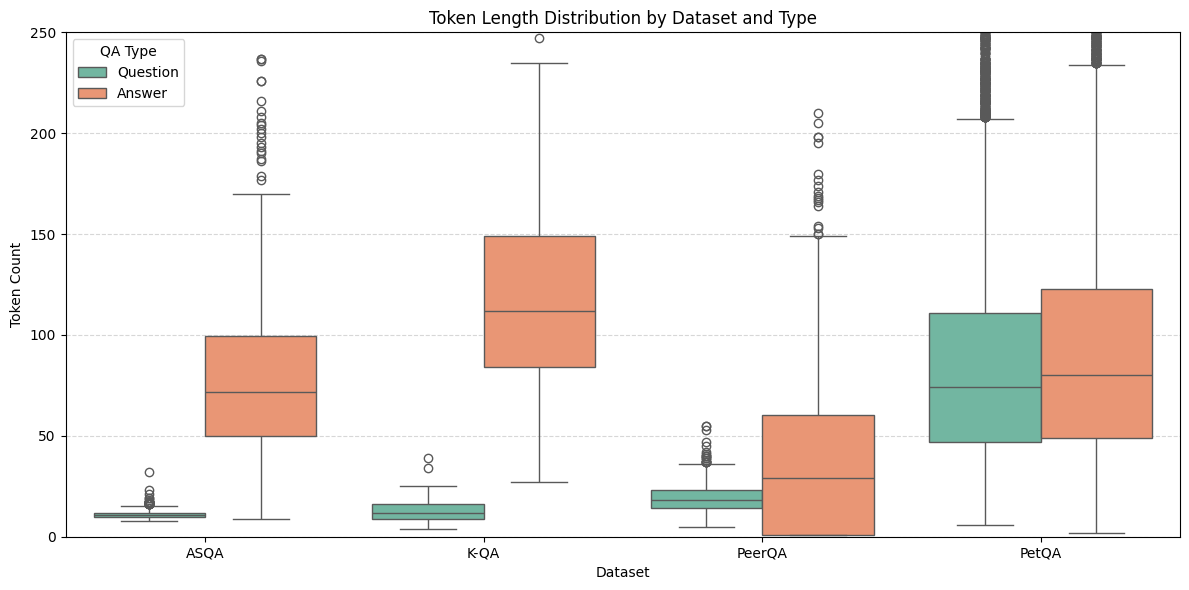

In [ ]:
datasets = {
    "ASQA": (question_token_counts_asqa, answer_token_counts_asqa),
    "K-QA": (question_token_counts_kqa, answer_token_counts_kqa),
    "PeerQA": (question_token_counts_peerqa, answer_token_counts_peerqa),
    "PetQA": (question_token_counts_petqa, answer_token_counts_petqa),
}

# 시각화를 위한 long-form DataFrame 생성
records = []
for dataset_name, (q_list, a_list) in datasets.items():
    records += [{"Dataset": dataset_name, "Type": "Question", "Tokens": t} for t in q_list]
    records += [{"Dataset": dataset_name, "Type": "Answer", "Tokens": t} for t in a_list]

df = pd.DataFrame(records)

# boxplot 그리기
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Dataset", y="Tokens", hue="Type", palette="Set2")

plt.title("Token Length Distribution by Dataset and Type")
plt.xlabel("Dataset")
plt.ylim(0, 250)
plt.ylabel("Token Count")
plt.legend(title="QA Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


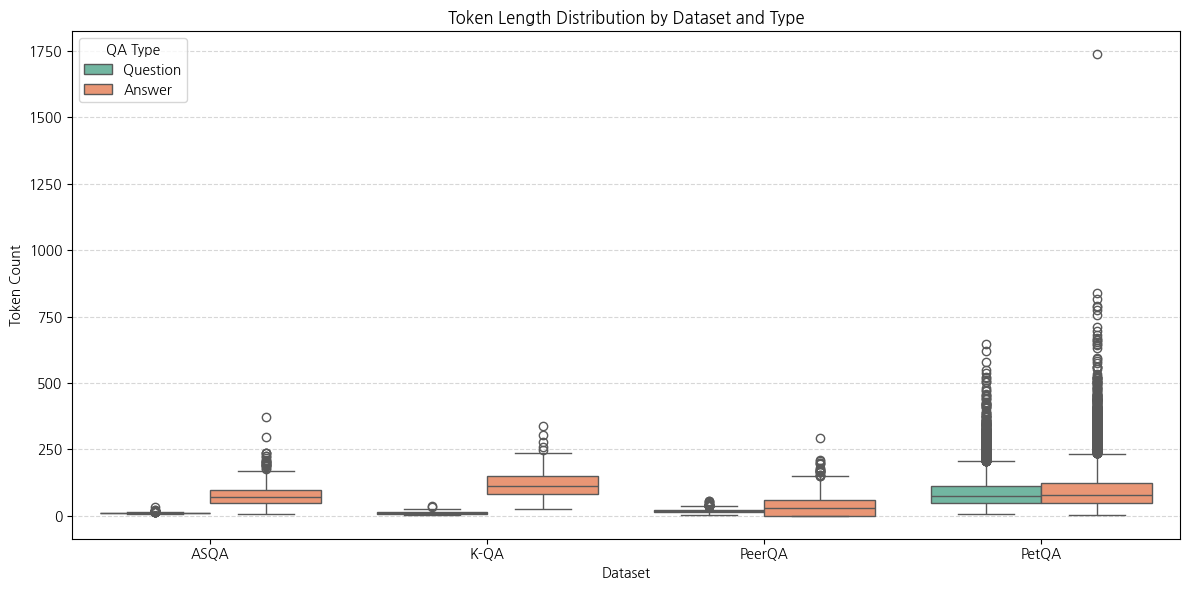

In [ ]:
datasets = {
    "ASQA": (question_token_counts_asqa, answer_token_counts_asqa),
    "K-QA": (question_token_counts_kqa, answer_token_counts_kqa),
    "PeerQA": (question_token_counts_peerqa, answer_token_counts_peerqa),
    "PetQA": (question_token_counts_petqa, answer_token_counts_petqa),
}

# 시각화를 위한 long-form DataFrame 생성
records = []
for dataset_name, (q_list, a_list) in datasets.items():
    records += [{"Dataset": dataset_name, "Type": "Question", "Tokens": t} for t in q_list]
    records += [{"Dataset": dataset_name, "Type": "Answer", "Tokens": t} for t in a_list]

df = pd.DataFrame(records)

# boxplot 그리기
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Dataset", y="Tokens", hue="Type", palette="Set2")

plt.title("Token Length Distribution by Dataset and Type")
plt.xlabel("Dataset")
# plt.ylim(500, 250)
plt.ylabel("Token Count")
plt.legend(title="QA Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
file_path = "/home/work/factchecking/PetQA/data/processed/test.json"

question_token_counts_petqa = []
answer_token_counts_petqa = []

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

for entry in data:
    title = entry.get("title")
    content = entry.get("content")
    # question_text = f"{title}\n{content}"
    # answer_text = entry.get("answer")
    question_text = entry.get("preprocessed_question")
    answer_text = entry.get("preprocessed_answer")

    question_token_counts_petqa.append(get_token_count(question_text))
    answer_token_counts_petqa.append(get_token_count(answer_text))

avg_question_tokens_petqa = sum(question_token_counts_petqa) / len(question_token_counts_petqa)
avg_answer_tokens_petqa = sum(answer_token_counts_petqa) / len(answer_token_counts_petqa)

print(f"PetQA 샘플 수: {len(question_token_counts_petqa)}")
print(f"PetQA 평균 질문 토큰 수: {avg_question_tokens_petqa:.2f}")
print(f"PetQA 최대 질문 토큰 수: {max(question_token_counts_petqa)}")
print(f"PetQA 최소 질문 토큰 수: {min(question_token_counts_petqa)}")

print(f"PetQA 평균 답변 토큰 수: {avg_answer_tokens_petqa:.2f}")
print(f"PetQA 최대 답변 토큰 수: {max(answer_token_counts_petqa)}")
print(f"PetQA 최소 답변 토큰 수: {min(answer_token_counts_petqa)}")

PetQA 샘플 수: 10000
PetQA 평균 질문 토큰 수: 88.04
PetQA 최대 질문 토큰 수: 645
PetQA 최소 질문 토큰 수: 6
PetQA 평균 답변 토큰 수: 99.28
PetQA 최대 답변 토큰 수: 1736
PetQA 최소 답변 토큰 수: 2


Avg gold answer tokens: 98.58
Avg summarized answer tokens: 67.35


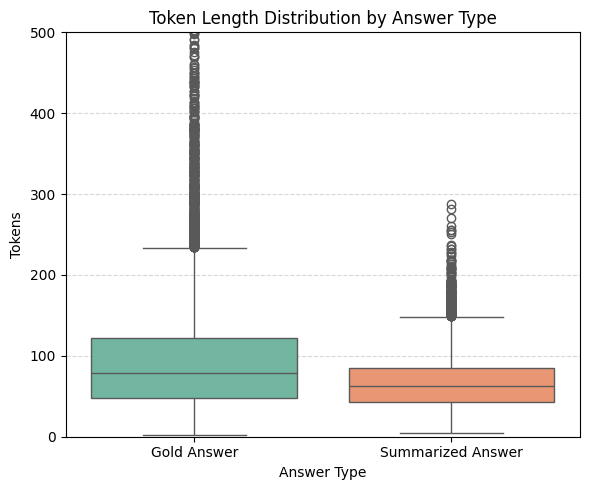

In [26]:
file_path = "/home/work/factchecking/PetQA/data/processed/summarization_test.json"

gold_answer_token_counts = []
summarized_answer_token_counts = []

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

records = []
for item in data:
    gold_answer_text = item.get("preprocessed_answer")
    summarized_answer_text = item.get("summarized_answer")

    gold_tokens = get_token_count(gold_answer_text)
    summarized_tokens = get_token_count(summarized_answer_text)
    
    gold_answer_token_counts.append(gold_tokens)
    summarized_answer_token_counts.append(summarized_tokens)
    
    records.append({
        "Type": "Gold Answer",
        "Tokens": gold_tokens
    })
    records.append({
        "Type": "Summarized Answer",
        "Tokens": summarized_tokens
    })

avg_gold_answer_tokens = sum(gold_answer_token_counts) / len(gold_answer_token_counts)
avg_summarized_answer_tokens = sum(summarized_answer_token_counts) / len(summarized_answer_token_counts)

print(f"Avg gold answer tokens: {avg_gold_answer_tokens:.2f}")
print(f"Avg summarized answer tokens: {avg_summarized_answer_tokens:.2f}")

df = pd.DataFrame(records)

# boxplot 그리기
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="Type", y="Tokens", hue="Type", palette="Set2")

plt.title("Token Length Distribution by Answer Type")
plt.xlabel("Answer Type")
plt.ylim(0, 500)
plt.ylabel("Tokens")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


19


### 전문가 답변과 일반인 답변 비교

In [10]:
import json
from collections import defaultdict
file_path = "/home/work/factchecking/PetQA/data/interim/cleaned_data.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

q_id_to_answer_types = defaultdict(set)

for item in data:
    q_id = item["q_id"]
    answer_type = item["answer_type"]
    q_id_to_answer_types[q_id].add(answer_type)

# expert + nonexpert 모두 존재하는 q_id만 필터링
mixed_q_ids = [q_id for q_id, types in q_id_to_answer_types.items() 
               if "expert" in types and "nonexpert" in types]

print(f"처리 대상: /cleaned_data.json")
print("전처리 후 E&NE 모두 존재하는 샘플 수:", len(mixed_q_ids))

mixed_samples = [item for item in data if item["q_id"] in mixed_q_ids]
# output_path = "./mixed_expert_nonexpert_answers.json"
# with open(output_path, "w", encoding="utf-8") as f:
#     json.dump(mixed_samples, f, ensure_ascii=False, indent=2)

print(f"# QA pairs: {len(mixed_samples)}")

처리 대상: /cleaned_data.json
전처리 후 E&NE 모두 존재하는 샘플 수: 1394
# QA pairs: 2804


### LLM 기반 cleaning 전후 유사도 비교

In [11]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/cleaned_data.json"

ref_q = []
ref_a = []

cand_q = []
cand_a = []

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
print(f"PetQA 샘플 수: {len(data)}")

for item in data:
    ref_q.append(item["title"] + " " + item["content"])
    ref_a.append(item["answer"])
    cand_q.append(item["preprocessed_question"])
    cand_a.append(item["preprocessed_answer"])

PetQA 샘플 수: 55371


In [ ]:
from rouge import Rouge
from konlpy.tag import Okt
okt = Okt()
rouge = Rouge()

ref_q_morphs = [" ".join(okt.morphs(g)) for g in ref_q]
ref_a_morphs = [" ".join(okt.morphs(g)) for g in ref_a]
cand_q_morphs = [" ".join(okt.morphs(g)) for g in cand_q]
cand_a_morphs = [" ".join(okt.morphs(g)) for g in cand_a]

scores_q = []
for g, p in zip(cand_q_morphs, ref_q_morphs):
    scores_q.append(rouge.get_scores(g, p)[0]['rouge-l']['f'])

scores_a = []
for g, p in zip(cand_a_morphs, ref_a_morphs):
    scores_a.append(rouge.get_scores(g, p)[0]['rouge-l']['f'])

avg_rougeL_f1_q = sum(scores_q) / len(scores_q)
avg_rougeL_f1_a = sum(scores_a) / len(scores_a)

print(f"Avg ROUGE-L F1 for Question: {avg_rougeL_f1_q:.3f}")
print(f"Avg ROUGE-L F1 for Answer: {avg_rougeL_f1_a:.3f}")

In [4]:
from bert_score import score
q_pairs = [(r_q, c_q) for r_q, c_q in zip(ref_q, cand_q)]
rerference_q, candidate_q = zip(*q_pairs)
_, _, F1 = score(
    rerference_q,
    candidate_q, 
    lang="ko"  # 다국어 모델: "bert-base-multilingual-cased"
)
total_scores_q = F1.tolist()
avg_bertscore_f1_q = sum(total_scores_q) / len(total_scores_q)
print(f"Avg BERTScore F1 for Question: {avg_bertscore_f1_q:.3f}")

a_pairs = [(r_a, c_a) for r_a, c_a in zip(ref_a, cand_a)]
reference_a, candidate_a = zip(*a_pairs)
_, _, F1 = score(
    reference_a,
    candidate_a, 
    lang="ko"  # 다국어 모델: "bert-base-multilingual-cased"
)
total_scores_a = F1.tolist()
avg_bertscore_f1_a = sum(total_scores_a) / len(total_scores_a)
print(f"Avg BERTScore F1 for Answer: {avg_bertscore_f1_a:.3f}")

Avg BERTScore F1 for Question: 0.806
Avg BERTScore F1 for Answer: 0.854


# 통계량 및 분포

In [19]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/merged_data.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"전처리 전 # 게시글 샘플의 수: {len(data):,}")

전처리 전 # 게시글 샘플의 수: 63,376


In [1]:
import json
file_path = "/home/work/factchecking/PetQA/data/interim/cleaned_data.json"
with open(file_path, "r", encoding="utf-8") as f:
    cleaned_data = json.load(f)
print(f"전처리 후 # QA pairs: {len(cleaned_data):,}")

전처리 후 # QA pairs: 55,371


In [2]:
import json
file_path = "/home/work/factchecking/PetQA/src/preprocessing/extracted_data_w_badge.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
print(len(data))
print(data[0])

62018
{'q_id': 0, 'title': '고양이 발정', 'content': '안녕하세요 고양이를 키우고 있는 한 집사입니다.고양이를 키우게 된지\xa0약 10개월이 됬는데 터음에 중성화 수술을 해주려다가 부모님께서안된다 하셔서 못 해줬는데 최근에 부모님께서 중성화 수술을 하자고 하시네요.고양이 중성화 수술 지금 나이쯤(약 8개월)에 해도 늦지 않은 걸까요??', 'answers': [{'a_id': 0, 'answer_type': 'expert', 'answer': '안녕하세요. 지식iN 동물의료상담을 하고 있는 은평동물병원장 버드나무 이상철입니다. 일반적으로 고양이 중성화수술은\xa0생후 6개월령이 적정시기입니다. 8개월이면 많이 늦지 않았으니 너무 걱정하지 않으셔도 됩니다.', 'badge': '수의사', 'selected': True, 'answer_date': '2018.12.18.'}], 'question_date': '2018.12.17', 'animal_type': 'cat', 'link': 'https://kin.naver.com/qna/detail.naver?d1id=8&dirId=80511&docId=316821860&page=1&answerNo=1'}


In [3]:
selected_all_answer_type_q_ids = []
for item in data:
    selected_expert_flag = False
    selected_nonexpert_flag = False
    for answer in item["answers"]:
        if answer["answer_type"] == "expert" and answer["selected"]:
            selected_expert_flag = True
        if answer["answer_type"] == "nonexpert" and answer["selected"]:
            selected_nonexpert_flag = True
    if selected_expert_flag and selected_nonexpert_flag:
        selected_all_answer_type_q_ids.append(item["q_id"])
print(len(selected_all_answer_type_q_ids))

1987


In [5]:
q_ids = []
for item in cleaned_data:
    if item["q_id"] in selected_all_answer_type_q_ids or item["answer"] == "":
        q_ids.append(item["q_id"])
print(len(q_ids)) # 여기에 추가로 비어있는 answer를 제거하면 총 3,149건 제거

3103


In [8]:
import os
processed_dir = "/home/work/factchecking/PetQA/data/processed"
train_file = os.path.join(processed_dir, "train.json")
validation_file = os.path.join(processed_dir, "validation.json")
test_file = os.path.join(processed_dir, "test.json")

with open(train_file, "r", encoding="utf-8") as f:
    train_data = json.load(f)
    print(len(train_data))
with open(validation_file, "r", encoding="utf-8") as f:
    validation_data = json.load(f)
    print(len(validation_data))
with open(test_file, "r", encoding="utf-8") as f:
    test_data = json.load(f)
    print(len(test_data))

35371
10000
10000


In [10]:
train_to_remove_q_ids = []
for item in train_data:
    if item["q_id"] in q_ids:
        train_to_remove_q_ids.append(item["q_id"])

validation_to_remove_q_ids = []
for item in validation_data:
    if item["q_id"] in q_ids:
        validation_to_remove_q_ids.append(item["q_id"])

test_to_remove_q_ids = []
for item in test_data:
    if item["q_id"] in q_ids:
        test_to_remove_q_ids.append(item["q_id"])

print(len(train_to_remove_q_ids))
print(len(validation_to_remove_q_ids))
print(len(test_to_remove_q_ids))

1992
562
549


In [ ]:
new_train_data = []
for item in train_data:
    if item["q_id"] not in q_ids:
        new_train_data.append(item)

new_validation_data = []
for item in validation_data:
    if item["q_id"] not in q_ids:
        new_validation_data.append(item)

new_test_data = []
for item in test_data:
    if item["q_id"] not in q_ids:
        new_test_data.append(item)

print(len(new_train_data))
print(len(new_validation_data))
print(len(new_test_data))

33379
9438
9451


In [14]:
new_train_path = os.path.join(processed_dir, "train.json")
with open(new_train_path, "w", encoding="utf-8") as f:
    json.dump(new_train_data, f, ensure_ascii=False, indent=2)

new_validation_path = os.path.join(processed_dir, "validation.json")
with open(new_validation_path, "w", encoding="utf-8") as f:
    json.dump(new_validation_data, f, ensure_ascii=False, indent=2)

new_test_path = os.path.join(processed_dir, "test.json")
with open(new_test_path, "w", encoding="utf-8") as f:
    json.dump(new_test_data, f, ensure_ascii=False, indent=2)

In [ ]:
test_q_ids = []
for item in new_train_data:
    test_q_ids.append(item["q_id"])

for item in new_validation_data:
    test_q_ids.append(item["q_id"])

for item in new_test_data:
    test_q_ids.append(item["q_id"])

print(len(test_q_ids))

52268


In [19]:
for q_id in test_q_ids:
    if q_id in selected_all_answer_type_q_ids:
        print(q_id)

In [4]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import math
import re
import sys
from collections import Counter

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

55371


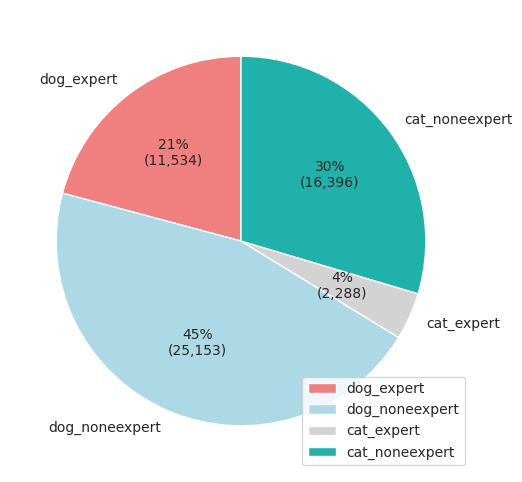

In [24]:
dog_expert = []
dog_noneexpert = []
cat_expert = []
cat_noneexpert = []

for item in data:
    if item['animal_type'] == 'dog':
        if item['answer_type'] == 'expert':
            dog_expert.append(item)
        else:
            dog_noneexpert.append(item)
    else:
        if item['answer_type'] == 'expert':
            cat_expert.append(item)
        else:
            cat_noneexpert.append(item)

labels = ['dog_expert', 'dog_noneexpert', 'cat_expert', 'cat_noneexpert']
sizes = [len(dog_expert), len(dog_noneexpert), len(cat_expert), len(cat_noneexpert)]
colors = ['lightcoral', 'lightblue', 'lightgray', 'lightseagreen']
total_size = sum(sizes)
print(total_size)

def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.0f}%\n({:,d})".format(pct, absolute)

plt.pie(
    sizes,
    labels=labels,
    startangle=90,
    autopct=lambda pct: func(pct, sizes),
    colors=colors,
)
plt.legend(labels)
plt.show()

음절의 수 계산

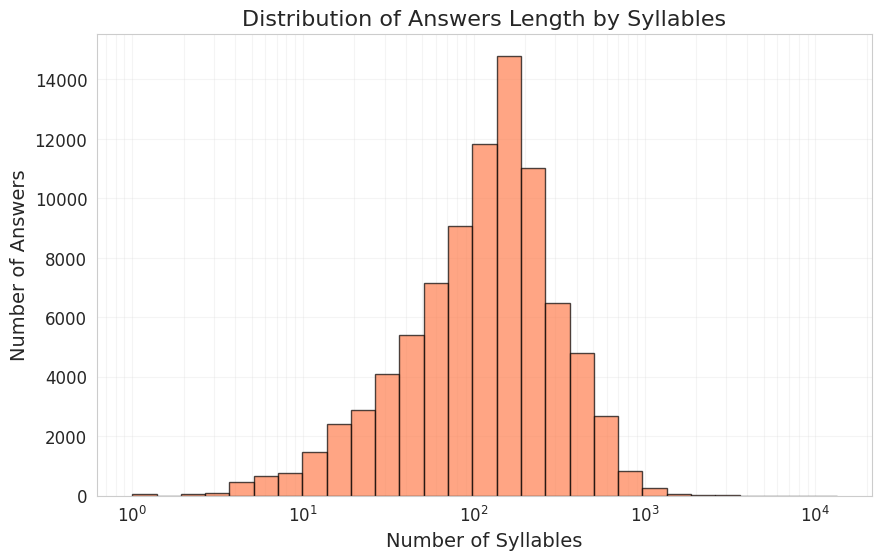

min_syllable: 0
max_syllable: 11128


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def count_korean_syllables(text):
	return sum(1 for char in text if '가' <= char <= '힣')

syllable_counts = {}
for item in data:
	# title = item.get('title')
	# content = item.get('content', '')
	# question = f"{title}\n{content}".strip()
	# if question:
	#     syllable_cnt = count_korean_syllables(question)
	#     syllable_counts[syllable_cnt] = syllable_counts.get(syllable_cnt, 0) + 1
	answers = item.get('answers', [])
	for answer in answers:
		answer_text = answer.get('answer', '')
		if answer_text:
			syllable_cnt = count_korean_syllables(answer_text)
			syllable_counts[syllable_cnt] = syllable_counts.get(syllable_cnt, 0) + 1

syllables = list(syllable_counts.keys())
counts = list(syllable_counts.values())

# 로그 스케일 빈 생성
min_syllable = min(syllables) if syllables else 1
max_syllable = max(syllables) if syllables else 10000

bins = np.logspace(np.log10(max(1, min_syllable * 0.8)), np.log10(max_syllable * 1.2), num=30)

plt.figure(figsize=(10, 6))
plt.hist(syllables, bins=bins, weights=counts, color='coral', edgecolor='black', alpha=0.7)
plt.xscale('log') # x축을 로그 스케일로 설정
plt.xlabel('Number of Syllables', fontsize=14)
plt.ylabel('Number of Answers', fontsize=14)
plt.title('Distribution of Answers Length by Syllables', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"min_syllable: {min_syllable}")
print(f"max_syllable: {max_syllable}")


In [28]:
animal_types = [item['animal_type'] for item in data]
animal_counter = Counter(animal_types)
for animal, count in animal_counter.items():
	percentage = (count / len(data)) * 100
	print(f"{animal}: {count:,}개 ({percentage:.2f}%)")

cat: 18,684개 (33.74%)
dog: 36,687개 (66.26%)


질문당 1~5개의 답변이 존재
평균 답변 수: 1.41
전문가 답변 채택 비율: 99%
일반인 답변 채택 비율: 68%


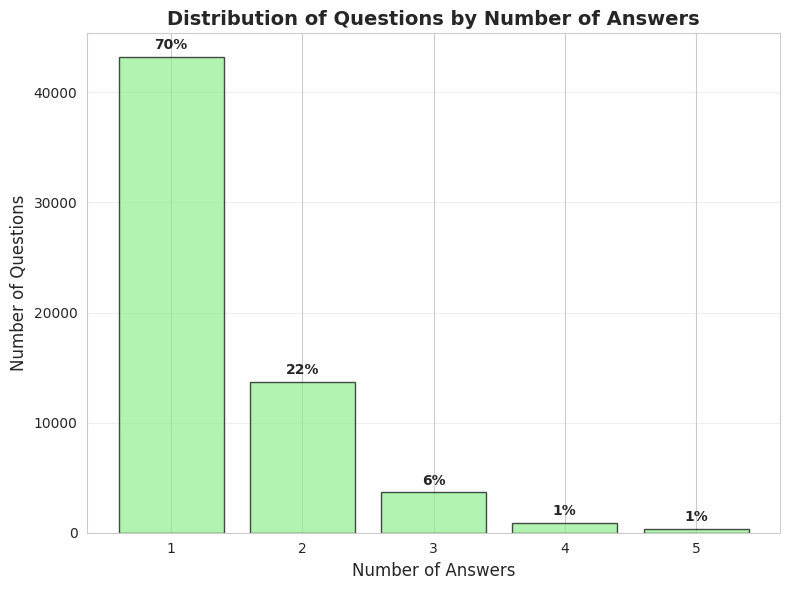

In [41]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

file_path = "/home/work/factchecking/PetQA/data/interim/unique_data.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

expert_answer_cnt = 0
nonexpert_answer_cnt = 0
selected_expert_answer_cnt = 0
selected_nonexpert_answer_cnt = 0

answer_cnt_per_question = []
for item in data:
    answer_cnt_per_question.append(len(item["answers"]))
    for answer in item["answers"]:
        if answer["answer_type"] == "expert":
            expert_answer_cnt += 1
            if answer["selected"]:
                selected_expert_answer_cnt += 1
        elif answer["answer_type"] == "nonexpert":
            nonexpert_answer_cnt += 1
            if answer["selected"]:
                selected_nonexpert_answer_cnt += 1

print(f"질문당 {min(answer_cnt_per_question)}~{max(answer_cnt_per_question)}개의 답변이 존재")
print(f"평균 답변 수: {np.mean(answer_cnt_per_question):.2f}")

print(f"전문가 답변 채택 비율: {int((selected_expert_answer_cnt/expert_answer_cnt)*100)}%")
print(f"일반인 답변 채택 비율: {int((selected_nonexpert_answer_cnt/nonexpert_answer_cnt)*100)}%")

answer_count_distribution = Counter(answer_cnt_per_question)

counts = list(answer_count_distribution.keys())
frequencies = [answer_count_distribution[c] for c in counts]

plt.figure(figsize=(8, 6))
plt.bar(counts, frequencies, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('Distribution of Questions by Number of Answers', fontsize=14, fontweight='bold')
plt.xlabel('Number of Answers', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(counts)
plt.grid(True, alpha=0.3, axis='y')

total = sum(frequencies)
for i, freq in enumerate(frequencies):
	percent = freq / total * 100
	plt.text(counts[i], freq + max(frequencies)*0.01,
			 f'{percent:.0f}%',
			ha='center', va='bottom', fontweight='bold'
	)

plt.tight_layout()
plt.show()

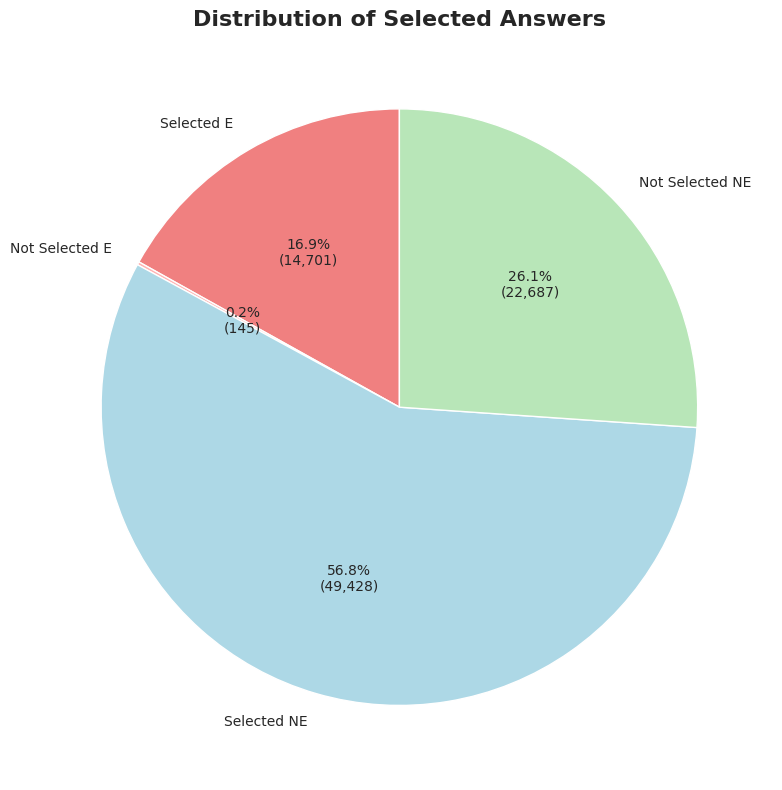

In [42]:
# 4개 섹션으로 분할된 상세 파이차트
plt.figure(figsize=(12, 8))

# 데이터 준비
labels_detailed = ['Selected E', 'Not Selected E', 'Selected NE', 'Not Selected NE']
sizes_detailed = [selected_expert_answer_cnt, expert_answer_cnt - selected_expert_answer_cnt, 
				  selected_nonexpert_answer_cnt, nonexpert_answer_cnt - selected_nonexpert_answer_cnt]
colors_detailed = ['lightcoral', '#FFB3B3', 'lightblue', '#B8E6B8']

def make_autopct(values):
	def my_autopct(pct):
		total = sum(values)
		val = int(round(pct*total/100.0))
		return f'{pct:.1f}%\n({val:,})'
	return my_autopct

wedges, texts, autotexts = plt.pie(sizes_detailed, labels=labels_detailed, colors=colors_detailed,
								   autopct=make_autopct(sizes_detailed), startangle=90, textprops={'fontsize': 10})

plt.title('Distribution of Selected Answers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
# 질문별 종합 정보 생성
question_data = []
for item in data:
	question_info = {
		'q_id': item['q_id'],
		'animal_type': item['animal_type'],
		'num_answers': len(item['answers']),
		'has_expert': any(ans['answer_type'] == 'expert' for ans in item['answers']),
		'has_selected': any(ans['selected'] for ans in item['answers']),
		'num_selected': sum(ans['selected'] for ans in item['answers']),
		'num_expert': sum(1 for ans in item['answers'] if ans['answer_type'] == 'expert'),
		'num_nonexpert': sum(1 for ans in item['answers'] if ans['answer_type'] == 'nonexpert')
	}
	question_data.append(question_info)

questions_df = pd.DataFrame(question_data)
answers_df = pd.DataFrame(all_answers)

print(f"기본 통계:")
print(f"전문가 답변이 있는 샘플의 수: {questions_df['has_expert'].sum():,}개 ({questions_df['has_expert'].mean()*100:.2f}%)")
print(f"채택된 답변이 있는 샘플의 수: {questions_df['has_selected'].sum():,}개 ({questions_df['has_selected'].mean()*100:.2f}%)")


기본 통계:
전문가 답변이 있는 샘플의 수: 14,845개 (24.01%)
채택된 답변이 있는 샘플의 수: 61,825개 (100.00%)


In [163]:
for animal in questions_df['animal_type'].unique():
	print(f"\n{animal.upper()} 분석:")
	print("-" * 30)
	
	animal_questions = questions_df[questions_df['animal_type'] == animal]
	animal_answers = answers_df[answers_df['animal_type'] == animal]
	
	# 기본 통계
	print(f"질문 수: {len(animal_questions):,}")
	print(f"총 답변 수: {len(animal_answers):,}")
	print(f"평균 답변 수: {animal_questions['num_answers'].mean():.2f}")
	
	# 답변 유형 분석
	expert_count_animal = len(animal_answers[animal_answers['answer_type'] == 'expert'])
	expert_ratio = expert_count_animal / len(animal_answers) * 100 if len(animal_answers) > 0 else 0
	print(f"전문가 답변 비율: {expert_ratio:.2f}% ({expert_count_animal:,}/{len(animal_answers):,})")
	
	# # 채택률 분석
	# selection_ratio = animal_answers['selected'].mean() * 100
	# selected_count = animal_answers['selected'].sum()
	# print(f"답변 채택률: {selection_ratio:.2f}% ({selected_count:,}/{len(animal_answers):,})")


CAT 분석:
------------------------------
질문 수: 21,235
총 답변 수: 29,562
평균 답변 수: 1.39
전문가 답변 비율: 8.28% (2,448/29,562)
답변 채택률: 73.15% (21,626/29,562)

DOG 분석:
------------------------------
질문 수: 40,790
총 답변 수: 57,869
평균 답변 수: 1.42
전문가 답변 비율: 21.76% (12,592/57,869)
답변 채택률: 73.94% (42,790/57,869)


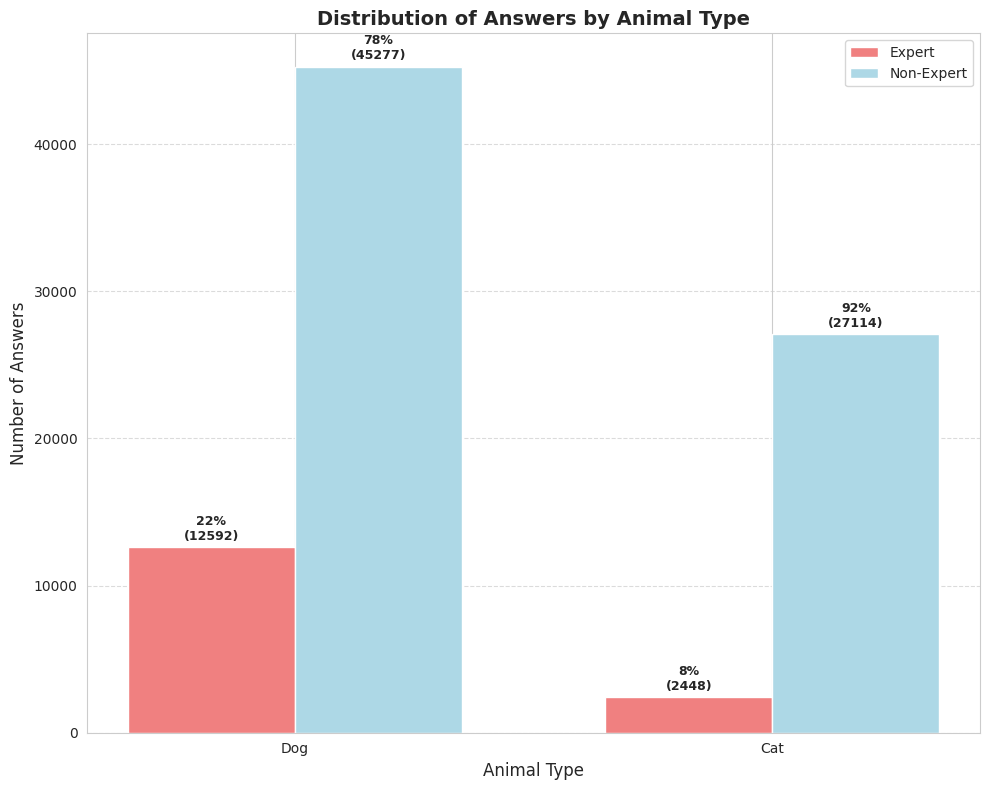

In [177]:
# Dog와 Cat의 전문가/일반인 답변 개수 계산
dog_expert_count = answers_df[(answers_df['animal_type'] == 'dog') & (answers_df['answer_type'] == 'expert')].shape[0]
dog_non_expert_count = answers_df[(answers_df['animal_type'] == 'dog') & (answers_df['answer_type'] == 'nonexpert')].shape[0]
cat_expert_count = answers_df[(answers_df['animal_type'] == 'cat') & (answers_df['answer_type'] == 'expert')].shape[0]
cat_non_expert_count = answers_df[(answers_df['animal_type'] == 'cat') & (answers_df['answer_type'] == 'nonexpert')].shape[0]

animals = ['Dog', 'Cat']
expert_counts = [dog_expert_count, cat_expert_count]
non_expert_counts = [dog_non_expert_count, cat_non_expert_count]

x = np.arange(len(animals))
width = 0.35  # 막대의 너비

fig, ax = plt.subplots(figsize=(10, 8))

rects1 = ax.bar(x - width/2, expert_counts, width, label='Expert', color='lightcoral')
rects2 = ax.bar(x + width/2, non_expert_counts, width, label='Non-Expert', color='lightblue')

ax.set_xlabel('Animal Type', fontsize=12)
ax.set_ylabel('Number of Answers', fontsize=12)
ax.set_title('Distribution of Answers by Animal Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(animals, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 각 막대 위에 수치 표시 함수
total_counts = [dog_expert_count + dog_non_expert_count, cat_expert_count + cat_non_expert_count]

def autolabel_percent(rects, counts, total):
	for rect, count, tot in zip(rects, counts, total):
		height = rect.get_height()
		percent = height / tot * 100 if tot > 0 else 0
		ax.annotate(f'{percent:.0f}%\n({int(height)})',
					xy=(rect.get_x() + rect.get_width() / 2, height),
					xytext=(0, 3),  # 3 points vertical offset
					textcoords="offset points",
					ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel_percent(rects1, expert_counts, total_counts)
autolabel_percent(rects2, non_expert_counts, total_counts)

fig.tight_layout()
plt.show()

### 토큰의 길이 계산

In [ ]:
import tiktoken

# 응답 비용 계산

In [18]:
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import anthropic
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [ ]:
df = pd.read_json("/home/work/factchecking/PetQA/data/interim/petqa.json")

In [178]:
import math
models = {
	'gpt-4o-mini': {"input_token": 0.15, "output_token": 0.60, "avg_output_token": 127},
	'claude-3-haiku': {"input_token": 0.25, "output_token": 1.25, "avg_output_token": 238},
	'gemini-2.0-flash': {"input_token": 0.1, "output_token": 0.4, "avg_output_token": 122},
}

avg_input_token = {
	"0": [265, 417, 231],
	"1": [567, 916, 510],
	"3": [1181, 1933, 1074],
	"6": [2106, 3464, 1925],
}

total_cost = 0

print("전처리 (gpt-4o-mini)")
filtering_size = 62025
cost = models["gpt-4o-mini"]["input_token"] * 584 + models["gpt-4o-mini"]["output_token"] * 1
cost = math.ceil((cost * filtering_size) / 1000000)
total_cost += cost
print(f"필터링 비용: {cost} USD")

cleaning_size = 62025
cost = models["gpt-4o-mini"]["input_token"] * 760 + models["gpt-4o-mini"]["output_token"] * 278
cost = math.ceil((cost * cleaning_size) / 1000000)
total_cost += cost
print(f"클리닝 비용: {cost} USD")
print("---"*10)

print("답변 생성 비용")
test_size = 2000  # 500 * 4
for i, (model_name, price) in enumerate(models.items()):
	for shot, tokens in avg_input_token.items():
		# 입력 형식에 따른 비용 고려
		cost = 2 * (price["input_token"] * tokens[i] + price["output_token"] * price["avg_output_token"])
		cost = math.ceil((cost * test_size) / 1000000)
		total_cost += cost
		print(f"{model_name}-{shot}: {cost} USD")
	print("---"*10)

print(f"총 비용: {total_cost} USD")

전처리 (gpt-4o-mini)
필터링 비용: 6 USD
클리닝 비용: 18 USD
------------------------------
답변 생성 비용
gpt-4o-mini-0: 1 USD
gpt-4o-mini-1: 1 USD
gpt-4o-mini-3: 2 USD
gpt-4o-mini-6: 2 USD
------------------------------
claude-3-haiku-0: 2 USD
claude-3-haiku-1: 3 USD
claude-3-haiku-3: 4 USD
claude-3-haiku-6: 5 USD
------------------------------
gemini-2.0-flash-0: 1 USD
gemini-2.0-flash-1: 1 USD
gemini-2.0-flash-3: 1 USD
gemini-2.0-flash-6: 1 USD
------------------------------
총 비용: 48 USD
